In [222]:
import numpy as np
import pandas as pd
import re
from functools import reduce
import seaborn as sns
import json
import pickle
from collections import Counter

In [223]:
#显示所有列
pd.set_option('display.max_columns', None)
#显示所有行
pd.set_option('display.max_rows', None)
#设置value的显示长度为100，默认为50
pd.set_option('max_colwidth',100)

In [224]:
pwd

'/Users/hwang/Desktop/repo/academic-libraries-in-China'

# 1. data cleaning

In [225]:
dfName = ['collection', 'collectionEB', 'collectionEJ', 'collectionPB', 'collectionPJ', 'download', 'education',
          'expenditureLiterature', 'expenditureLiteratureE', 'expenditureLiteratureP', 'expenditureTotal', 'floor',
          'hours', 'loan', 'seats', 'staffCasual', 'staffFixedTerm', 'staffPermanent']

In [226]:
# excel filename, remain the same across all directories
fileName = ['analysis' + str(year) + '.xls' for year in range(2010, 2019+1)]

In [248]:
# list of dataframes containing all data given one field name
def raw2df(var):
    dfs=[pd.read_excel(open('./raw/'+ var +'/' + filename, 'rb'),
                       usecols=[1,2],
                       names=['school', 'data'],
                       dtype={'school':np.object, 'data': np.float64})
     for filename in fileName]
    # merge dfs
    df_merged = reduce(lambda  left, right: pd.merge(left, right, on=['school'],
                                            how='outer'), dfs)
    df_merged = df_merged.dropna(how='all')
    # set column label to year
    df_merged.columns=['school']+[str(year) for year in range(2010, 2019+1)]
    return df_merged

In [249]:
# check overlap school names
df_merged=raw2df('collection')
df_merged[df_merged.duplicated('school', keep=False)].dropna(how='all')

# Done, no overlap in school name

Empty DataFrame
Columns: [school, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
Index: []

# 2. data construction

In [250]:
# get merged dataframes
# leave staff field unsettled for now
for var in dfName:
    exec("""%s = raw2df('%s')""" % (var, var))

In [481]:
# # find all school names
# messySchoolName= list(floor.school)+list(expenditureTotal.school)+list(expenditureLiterature.school)+\
#  list(expenditureLiteratureP.school)+list(expenditureLiteratureE.school)+\
#  list(collection.school)+list(collectionPB.school)+list(collectionEB.school)+\
#  list(collectionPJ.school)+list(collectionEJ.school)+list(seats.school)+list(hours.school)+\
#  list(loan.school)+list(download.school)+list(education.school)+list(staffPermanent.school)+\
#  list(staffFixedTerm.school)+list(staffCasual.school)
# # remove duplicates
# messySchoolName = pd.Series(list(set(messySchoolName)))
# # messySchoolName.to_excel('messySchoolName.xlsx')

In [251]:
# step0: construct dfs
rename = pd.read_csv('./rename.csv')

In [252]:
renameDict = rename.set_index('originalName').T.to_dict('list')
# convert list to str in dict values
for k, v in renameDict.items():
    renameDict[k] = renameDict[k][0]

In [253]:
# step1: regularize school names
for df in dfName:
    exec("""%s.replace(renameDict, inplace=True)""" % (df))
# this line will create duplicates🤢🤢🤢🤢🤢🤢🤢 must check in the future

In [254]:
# ready to drop schools not containe in the MOE HEIs namelist, 2019
toDrop = pd.read_csv('./drop.csv')

In [255]:
# set index as school names aiming at faciliating drop invalid schools
for df in dfName:
    exec("""%s.set_index('school', inplace=True)""" % (df))

In [256]:
# step2: drop invalid schools
for school in list(toDrop.originalName):
    for df in dfName:
        exec("""%s.drop([school], inplace=True, errors='ignore')""" % (df))

In [16]:
# step3: merge libraries already merged in the reality but not reflexed in the SCAL database
# this can be devided into two steps, first, add number (by year) of the originalName to the mergeTo school
# Then delete the originalName school

In [257]:
# grab data for merging
merge = pd.read_csv('./merge.csv')
mergeDict = merge.set_index('originalName').T.to_dict('list')
# convert list to str in dict values
for k, v in mergeDict.items():
    mergeDict[k] = mergeDict[k][0]

In [258]:
# floor_t.loc['中山大学图书馆', :] = floor_t.loc['中山大学图书馆', :] + floor_t.loc['扬州大学图书馆', :]
# step 3.1 add up
# but be causious, the opening hours cannot be added
# some practically set max(x1, x2) as the operation hours

# deal with hours
for original, mergeTo in mergeDict.items():
    for year in range(2010, 2019+1):
        try:
            hours.loc[mergeTo, year] = max(hours.loc[mergeTo, year], hours.loc[original, year])
        except:
            pass

# deal with 
dfNameWithoutHours = [x for x in dfName if x!= 'hours']
for original, mergeTo in mergeDict.items():
    for df in dfNameWithoutHours:
        try:
            exec("""%s.loc[mergeTo, :] = %s.loc[mergeTo, :] + %s.loc[original, :]""" % (df, df, df))
        except:
            pass


In [259]:
# step 3.2 delete invalid schools
for school in list(mergeDict.keys()):
    for df in dfName:
        exec("""%s.drop([school], inplace=True, errors='ignore')""" % (df))

In [261]:
# step 4: check duplicate in school name
index = list(expenditureLiterature.index)
# index_noDuplicate = list(set(index))
[k for k,v in Counter(index).items() if v>1]
# do this for all the dfs, already done for all fields in expenditure(Total/Literature/LiteratureP/LiteratureE)

[]

In [247]:
expenditureTotal.loc['河北民族师范学院图书馆',:]

2010       2011  2012       2013  2014       2015  2016  \
school                                                                      
河北民族师范学院图书馆  1720000.0  5740841.0   NaN  1405000.0   NaN        NaN   NaN   
河北民族师范学院图书馆        NaN        NaN   NaN        NaN   NaN  1734278.0   NaN   

             2017  2018       2019  
school                              
河北民族师范学院图书馆   NaN   NaN        NaN  
河北民族师范学院图书馆   NaN   NaN  1247400.0

In [ ]:
dfName = ['collection', 'collectionEB', 'collectionEJ', 'collectionPB', 'collectionPJ', 'download', 'education',
          'expenditureLiterature', 'expenditureLiteratureE', 'expenditureLiteratureP', 'expenditureTotal', 'floor',
          'hours', 'loan', 'seats', 'staffCasual', 'staffFixedTerm', 'staffPermanent']

In [ ]:
# step 5: assign location and type labels to dfs

In [284]:
labels = pd.read_excel('labels.xlsx')

In [285]:
labels

school                       type          region  \
0                    北京大学            Project 985/211         Beijing   
1                  中国人民大学            Project 985/211         Beijing   
2                    清华大学            Project 985/211         Beijing   
3                  北京交通大学            Project 985/211         Beijing   
4                  北京工业大学            Project 985/211         Beijing   
5                北京航空航天大学            Project 985/211         Beijing   
6                  北京理工大学            Project 985/211         Beijing   
7                  北京科技大学            Project 985/211         Beijing   
8                  北方工业大学  Common University/College         Beijing   
9                  北京化工大学            Project 985/211         Beijing   
10                 北京工商大学  Common University/College         Beijing   
11                 北京服装学院  Common University/College         Beijing   
12                 北京邮电大学            Project 985/211         Beijing   
13                 北京印刷学院  Common University/College         Beijing   
14                 北京建筑大学  Common University/College         Beijing   
15               北京石油化工学院  Common University/College         Beijing   
16               北京电子科技学院  Common University/College         Beijing   
17                 中国农业大学            Project 985/211         Beijing   
18                  北京农学院  Common University/College         Beijing   
19                 北京林业大学            Project 985/211         Beijing   
20                北京协和医学院  Common University/College         Beijing   
21                 首都医科大学  Common University/College         Beijing   
22                北京中医药大学            Project 985/211         Beijing   
23                 北京师范大学            Project 985/211         Beijing   
24                 首都师范大学  Common University/College         Beijing   
25                 首都体育学院  Common University/College         Beijing   
26                北京外国语大学            Project 985/211         Beijing   
27              北京第二外国语学院  Common University/College         Beijing   
28                 北京语言大学  Common University/College         Beijing   
29                 中国传媒大学            Project 985/211         Beijing   
30                 中央财经大学            Project 985/211         Beijing   
31               对外经济贸易大学            Project 985/211         Beijing   
32                 北京物资学院  Common University/College         Beijing   
33               首都经济贸易大学  Common University/College         Beijing   
34               中国消防救援学院  Common University/College         Beijing   
35                   外交学院  Common University/College         Beijing   
36               中国人民公安大学  Common University/College         Beijing   
37                 国际关系学院  Common University/College         Beijing   
38                 北京体育大学            Project 985/211         Beijing   
39                 中央音乐学院            Project 985/211         Beijing   
40                 中国音乐学院  Common University/College         Beijing   
41                 中央美术学院  Common University/College         Beijing   
42                 中央戏剧学院  Common University/College         Beijing   
43                 中国戏曲学院  Common University/College         Beijing   
44                 北京电影学院  Common University/College         Beijing   
45                 北京舞蹈学院  Common University/College         Beijing   
46                 中央民族大学            Project 985/211         Beijing   
47                 中国政法大学            Project 985/211         Beijing   
48                 华北电力大学            Project 985/211         Beijing   
49                 中华女子学院  Common University/College         Beijing   
50               北京信息科技大学  Common University/College         Beijing   
51             中国矿业大学（北京）            Project 985/211         Beijing   
52             中国石油大学（北京）            Project 985/211         Beijing   
53             中国地质大学（北京）            Project 985/211         Beijing   
54                 北京联合大学  Common University/College       

In [286]:
labels.set_index('school').T.to_dict('list')

{'北京大学': ['Project 985/211', 'Beijing', 0, 1],
 '中国人民大学': ['Project 985/211', 'Beijing', 0, 1],
 '清华大学': ['Project 985/211', 'Beijing', 0, 1],
 '北京交通大学': ['Project 985/211', 'Beijing', 0, 1],
 '北京工业大学': ['Project 985/211', 'Beijing', 0, 1],
 '北京航空航天大学': ['Project 985/211', 'Beijing', 0, 1],
 '北京理工大学': ['Project 985/211', 'Beijing', 0, 1],
 '北京科技大学': ['Project 985/211', 'Beijing', 0, 1],
 '北方工业大学': ['Common University/College', 'Beijing', 1, 1],
 '北京化工大学': ['Project 985/211', 'Beijing', 0, 1],
 '北京工商大学': ['Common University/College', 'Beijing', 1, 1],
 '北京服装学院': ['Common University/College', 'Beijing', 1, 1],
 '北京邮电大学': ['Project 985/211', 'Beijing', 0, 1],
 '北京印刷学院': ['Common University/College', 'Beijing', 1, 1],
 '北京建筑大学': ['Common University/College', 'Beijing', 1, 1],
 '北京石油化工学院': ['Common University/College', 'Beijing', 1, 1],
 '北京电子科技学院': ['Common University/College', 'Beijing', 1, 1],
 '中国农业大学': ['Project 985/211', 'Beijing', 0, 1],
 '北京农学院': ['Common University/College', 'Beiji

In [289]:
region_labels = {k: v[-1] for (k, v) in labels.set_index('school').T.to_dict('list').items()}

In [290]:
region_labels

{'北京大学': 1,
 '中国人民大学': 1,
 '清华大学': 1,
 '北京交通大学': 1,
 '北京工业大学': 1,
 '北京航空航天大学': 1,
 '北京理工大学': 1,
 '北京科技大学': 1,
 '北方工业大学': 1,
 '北京化工大学': 1,
 '北京工商大学': 1,
 '北京服装学院': 1,
 '北京邮电大学': 1,
 '北京印刷学院': 1,
 '北京建筑大学': 1,
 '北京石油化工学院': 1,
 '北京电子科技学院': 1,
 '中国农业大学': 1,
 '北京农学院': 1,
 '北京林业大学': 1,
 '北京协和医学院': 1,
 '首都医科大学': 1,
 '北京中医药大学': 1,
 '北京师范大学': 1,
 '首都师范大学': 1,
 '首都体育学院': 1,
 '北京外国语大学': 1,
 '北京第二外国语学院': 1,
 '北京语言大学': 1,
 '中国传媒大学': 1,
 '中央财经大学': 1,
 '对外经济贸易大学': 1,
 '北京物资学院': 1,
 '首都经济贸易大学': 1,
 '中国消防救援学院': 1,
 '外交学院': 1,
 '中国人民公安大学': 1,
 '国际关系学院': 1,
 '北京体育大学': 1,
 '中央音乐学院': 1,
 '中国音乐学院': 1,
 '中央美术学院': 1,
 '中央戏剧学院': 1,
 '中国戏曲学院': 1,
 '北京电影学院': 1,
 '北京舞蹈学院': 1,
 '中央民族大学': 1,
 '中国政法大学': 1,
 '华北电力大学': 1,
 '中华女子学院': 1,
 '北京信息科技大学': 1,
 '中国矿业大学（北京）': 1,
 '中国石油大学（北京）': 1,
 '中国地质大学（北京）': 1,
 '北京联合大学': 1,
 '北京城市学院': 1,
 '中国青年政治学院': 1,
 '首钢工学院': 1,
 '中国劳动关系学院': 1,
 '北京吉利学院': 1,
 '首都师范大学科德学院': 1,
 '北京工商大学嘉华学院': 1,
 '北京邮电大学世纪学院': 1,
 '北京工业大学耿丹学院': 1,
 '北京警察学院': 1,
 '北京第二外国语学院中瑞酒店管理学院': 1,
 '中国科学院大学': 1,
 '中国

In [291]:
type_labels = {k: v[-2] for (k, v) in labels.set_index('school').T.to_dict('list').items()}

In [292]:
type_labels

{'北京大学': 0,
 '中国人民大学': 0,
 '清华大学': 0,
 '北京交通大学': 0,
 '北京工业大学': 0,
 '北京航空航天大学': 0,
 '北京理工大学': 0,
 '北京科技大学': 0,
 '北方工业大学': 1,
 '北京化工大学': 0,
 '北京工商大学': 1,
 '北京服装学院': 1,
 '北京邮电大学': 0,
 '北京印刷学院': 1,
 '北京建筑大学': 1,
 '北京石油化工学院': 1,
 '北京电子科技学院': 1,
 '中国农业大学': 0,
 '北京农学院': 1,
 '北京林业大学': 0,
 '北京协和医学院': 1,
 '首都医科大学': 1,
 '北京中医药大学': 0,
 '北京师范大学': 0,
 '首都师范大学': 1,
 '首都体育学院': 1,
 '北京外国语大学': 0,
 '北京第二外国语学院': 1,
 '北京语言大学': 1,
 '中国传媒大学': 0,
 '中央财经大学': 0,
 '对外经济贸易大学': 0,
 '北京物资学院': 1,
 '首都经济贸易大学': 1,
 '中国消防救援学院': 1,
 '外交学院': 1,
 '中国人民公安大学': 1,
 '国际关系学院': 1,
 '北京体育大学': 0,
 '中央音乐学院': 0,
 '中国音乐学院': 1,
 '中央美术学院': 1,
 '中央戏剧学院': 1,
 '中国戏曲学院': 1,
 '北京电影学院': 1,
 '北京舞蹈学院': 1,
 '中央民族大学': 0,
 '中国政法大学': 0,
 '华北电力大学': 0,
 '中华女子学院': 1,
 '北京信息科技大学': 1,
 '中国矿业大学（北京）': 0,
 '中国石油大学（北京）': 0,
 '中国地质大学（北京）': 0,
 '北京联合大学': 1,
 '北京城市学院': 1,
 '中国青年政治学院': 1,
 '首钢工学院': 1,
 '中国劳动关系学院': 1,
 '北京吉利学院': 1,
 '首都师范大学科德学院': 1,
 '北京工商大学嘉华学院': 1,
 '北京邮电大学世纪学院': 1,
 '北京工业大学耿丹学院': 1,
 '北京警察学院': 1,
 '北京第二外国语学院中瑞酒店管理学院': 1,
 '中国科学院大学': 1,
 '中国

In [293]:
collection

2010        2011        2012        2013  \
school                                                                   
中南财经政法大学图书馆             11511774.0  12331808.0   6825191.0         NaN   
山东大学图书馆                 10348616.0         NaN  12464019.0         NaN   
南京大学图书馆                  9274788.0   7727536.0   9195448.0         NaN   
北京大学图书馆                        NaN         NaN         NaN  10036872.0   
同济大学图书馆                  8750758.0   8501609.0         NaN   8998268.0   
电子科技大学图书馆                8042021.0   9571640.0  11681505.0         NaN   
郑州大学图书馆                  8018980.0   8661239.0         NaN   8914548.0   
华东师范大学图书馆                7730474.0         NaN   8593385.0   8896489.0   
南京理工大学图书馆                7368357.0   8345247.0   8301478.0   9079805.0   
陕西师范大学图书馆                7343143.0         NaN   8651228.0  10045011.0   
中山大学图书馆                  7024325.0   7294119.0   7506442.0   8991500.0   
浙江师范大学图书馆                6909573.0         NaN   7651970.0   9406283.0   
西北工业大学图书馆                6631088.0   7472088.0   8963888.0   9745161.0   
西安交通大学图书馆                6619770.0   7065417.0   7371412.0   6731286.0   
青岛科技大学图书馆                6614638.0         NaN         NaN   2079353.0   
复旦大学图书馆                  6402448.0   6854086.0   7137090.0   7501742.0   
清华大学图书馆                  6307762.0   6173295.0  13301745.0         NaN   
北京邮电大学图书馆                6173373.0         NaN         NaN   6357209.0   
上海大学图书馆                  6091275.0   5660670.0   5749416.0   6509214.0   
中国矿业大学图书馆                6044080.0   6411601.0   6834976.0   6716651.0   
浙江工业大学图书馆                6019417.0   4656359.0   5465097.0   5588461.0   
西北农林科技大学图书馆              5978612.0   7864793.0   8552744.0   9975224.0   
桂林电子科技大学图书馆              5880449.0         NaN         NaN         NaN   
武汉理工大学图书馆                5858016.0   6003608.0         NaN  13531734.0   
厦门大学图书馆                  5795950.0   6492789.0   7144070.0   7939450.0   
湖南大学图书馆                  5795136.0   5954119.0         NaN   6307138.0   
渤海大学图书馆                  5763957.0   5926586.0   2543624.0         NaN   
东南大学图书馆                  5672384.0         NaN   6339161.0   7038192.0   
西南财经大学图书馆                5500051.0   6008070.0   6052278.0   8574358.0   
贵州大学图书馆                  5463399.0   5563801.0   4863117.0   4679145.0   
上海师范大学图书馆                5419344.0         NaN   5945586.0   5931179.0   
河北师范大学图书馆                5342199.0   5730125.0   6452314.0   6824300.0   
重庆大学图书馆                  5302118.0  10673930.0         NaN   6423658.0   
黑龙江大学图书馆                 5299378.0   5381149.0   5895282.0   7376285.0   
山东理工大学图书馆                5241044.0   8714741.0   5545971.0   5842901.0   
河南大学图书馆                  5081824.0         NaN         NaN   9228128.0   
西安工程大学图书馆                4955312.0   5896700.0   6708722.0   7117174.0   
浙江大学图书馆                  4948952.0   7908124.0   8191548.0   8739786.0   
西安建筑科技大学图书馆              4930995.0   5034273.0   5830819.0   6080111.0   
怀化学院图书馆                  4924608.0         NaN         NaN         NaN   
南京师范大学图书馆                4908607.0   5557096.0   5957019.0   6849582.0   
徐州医科大学图书馆                4890567.0         NaN   5029035.0         NaN   
天津理工大学图书馆                4858389.0   4231074.0         NaN   4311831.0   
华中科技大学图书馆                4828448.0   5184310.0   5557300.0   7352015.0   
西安理工大学图书馆                4825225.0         NaN   5344406.0   5963917.0   
华东理工大学图书馆                4777182.0   5078569.0   5352717.0   5608605.0   
西安电子科技大学图书馆              4735309.0   5127373.0   5911116.0   6329081.0   
新乡医学院图书馆                 4717020.0         NaN         NaN   5523760.0   
辽宁工程技术大学图书馆              4706634.0         NaN   5548293.0   6167005.0   
华北电力大学图书馆                4675138.0   5645625.0   5792472.0   6328132.0   
集美大学图书馆                  4665909.0   4706331.0         NaN   6090562.0   
湖北文理学院图书馆                4542729.0         NaN   5309017.0         NaN   
浙江工商大学图书馆                4509653.0

In [272]:
# step 6: drop rows with all nan 
for df in dfName:
    exec("""%s.dropna(how='all', inplace=True)""" % (df))

In [ ]:
# step 7: line up highly unlikely data points

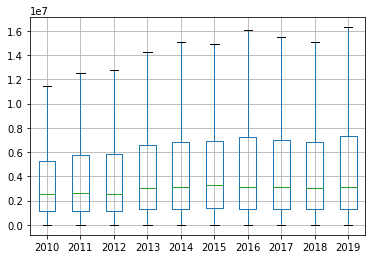

In [23]:
expenditureTotal.boxplot(showfliers=False)

In [615]:
expenditureTotal.loc[expenditureTotal['2019']>0.75e8]

2010        2011        2012        2013        2014  \
school                                                                
北京大学图书馆         NaN  47403642.5         NaN  45960323.5         NaN   
中山大学图书馆  25543850.0  26771200.0  35569000.0  30748800.0  41477240.0   

               2015        2016         2017         2018         2019  
school                                                                  
北京大学图书馆         NaN         NaN          NaN          NaN  105078073.0  
中山大学图书馆  45518400.0  76095232.0  133349480.0  131660912.0  142740096.0

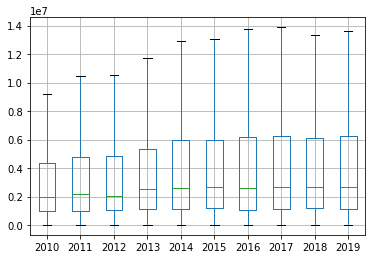

In [107]:
expenditureLiterature.boxplot(showfliers=False)

In [108]:
0.2e7

2000000.0

In [624]:
expenditureLiterature.loc[expenditureLiterature['2019']>0.5e8]

2010        2011        2012        2013        2014  \
school                                                                  
北京大学图书馆           NaN  38183780.0         NaN  39284837.5         NaN   
复旦大学图书馆    32963040.0  35862360.0  42318080.0  50004268.0  36976128.0   
清华大学图书馆    31837198.0  32369772.0  32206588.0  34086004.0  28662226.0   
浙江大学图书馆    29403286.0         NaN         NaN  40111180.0  41291900.0   
上海交通大学图书馆  27079774.0         NaN  28584730.0  30343000.0  37577712.0   
中山大学图书馆    21878366.0  25250900.0  28784000.0  28341900.0  37506040.0   
武汉大学图书馆           NaN  25013104.0  26218410.0  25801524.0  27877244.0   

                 2015        2016         2017         2018         2019  
school                                                                    
北京大学图书馆           NaN         NaN          NaN          NaN   84160332.0  
复旦大学图书馆    38557732.0  38384872.0   37429760.0   47479392.0   50220920.0  
清华大学图书馆    50888828.0  48102344.0   57144544.0   61442540.0   69579264.0  
浙江大学图书馆    39142912.0  54735528.0   63149584.0   64171220.0   62716760.0  
上海交通大学图书馆  33232140.0  34105308.0   39717776.0   42657656.0   60104416.0  
中山大学图书馆    42845400.0  70926928.0  123196976.0  107102896.0  132059656.0  
武汉大学图书馆    45641364.0  64877928.0   36430908.0   40568996.0   54928448.0

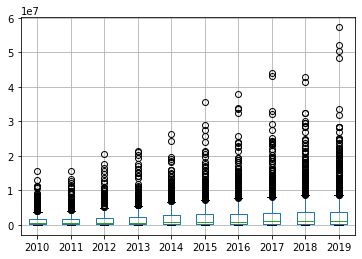

In [25]:
expenditureLiteratureE.boxplot(showfliers=True)

In [629]:
expenditureLiteratureE.loc[expenditureLiteratureE['2019']>0.3e8]

2010         2011        2012        2013        2014  \
school                                                                   
上海交通大学图书馆  15679950.0          NaN  17702030.0  20222712.0  26228414.0   
清华大学图书馆    13114304.0  15680344.00  20696426.0  21008604.0  18259946.0   
浙江大学图书馆    11346821.0          NaN         NaN  17805988.0  19754088.0   
中山大学图书馆    11188686.0   9066600.00  12013900.0  11988600.0  13750639.0   
北京大学图书馆           NaN  12154632.25         NaN  16121079.5         NaN   
华中科技大学图书馆         NaN          NaN  16609680.0  19341076.0  18427268.0   

                 2015        2016        2017        2018        2019  
school                                                                 
上海交通大学图书馆  24022214.0  22743766.0  29367552.0  32378356.0  48369092.0  
清华大学图书馆    35567080.0  33463396.0  43130952.0  42972832.0  52038548.0  
浙江大学图书馆    20560748.0  25735772.0  32170586.0  28572314.0  33666944.0  
中山大学图书馆    15131100.0  22629228.0  44150344.0  30156500.0  50536164.0  
北京大学图书馆    19749207.0         NaN         NaN         NaN  57309944.0  
华中科技大学图书馆  28911064.0  33822168.0  23913024.0  32355724.0  31961896.0

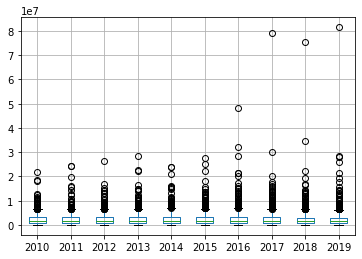

In [26]:
expenditureLiteratureP.boxplot(showfliers=True)

In [27]:
expenditureLiteratureP.loc[expenditureLiteratureP['2019']>0.8e8]

2010        2011        2012        2013        2014  \
school                                                                
中山大学图书馆  10620000.0  16184300.0  16770100.0  16353300.0  23755400.0   

               2015        2016        2017        2018        2019  
school                                                               
中山大学图书馆  27714300.0  48297700.0  79046632.0  75411000.0  81523488.0

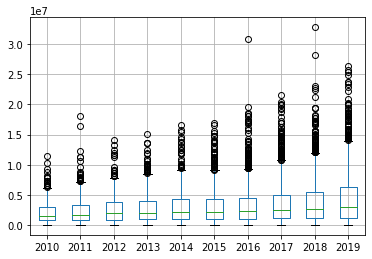

In [641]:
collection.boxplot(showfliers=True)

In [662]:
collection.loc[collection['2019']>2e7]

2010       2011        2012        2013        2014  \
school                                                                  
南京大学图书馆      9274788.0  7727536.0   9195448.0         NaN   9732871.0   
同济大学图书馆      8750758.0  8501609.0         NaN   8998268.0   9185475.0   
复旦大学图书馆      6402448.0  6854086.0   7137090.0   7501742.0   7706829.0   
清华大学图书馆      6307762.0  6173295.0  13301745.0         NaN  16539259.0   
武汉理工大学图书馆    5858016.0  6003608.0         NaN  13531734.0  14245904.0   
东南大学图书馆      5672384.0        NaN   6339161.0   7038192.0  12470398.0   
河北水利电力学院图书馆   420971.0   418806.0    447748.0    421765.0         NaN   
江南大学图书馆            NaN  5579393.0   6454250.0   6719421.0  11930368.0   
福建师范大学图书馆          NaN  5432871.0         NaN   6663199.0   7387344.0   
四川大学图书馆            NaN        NaN   9569707.0   9892925.0   9857885.0   
金陵科技学院图书馆          NaN        NaN         NaN         NaN   1222950.0   
长春工程学院图书馆          NaN        NaN         NaN         NaN         NaN   

                   2015        2016        2017        2018        2019  
school                                                                   
南京大学图书馆       9566691.0   9795565.0  16983144.0         NaN  20951619.0  
同济大学图书馆       9032200.0   9585926.0  19918086.0  21207805.0  23360246.0  
复旦大学图书馆       7985340.0  18352948.0  19908329.0  22719178.0  24797288.0  
清华大学图书馆      16968770.0  18033827.0  14577808.0  32781279.0  26354337.0  
武汉理工大学图书馆    14788797.0  17217282.0  19321179.0  18284981.0  20152045.0  
东南大学图书馆      13733831.0  17351629.0  15685718.0  16699757.0  25337818.0  
河北水利电力学院图书馆         NaN         NaN   4032931.0   5680769.0  22872895.0  
江南大学图书馆      12613761.0  19493099.0  21558086.0  23030284.0  22180730.0  
福建师范大学图书馆     8120225.0  10545442.0   9737764.0  12510842.0  25618124.0  
四川大学图书馆             NaN  12766490.0  11930212.0  28210487.0  23722068.0  
金陵科技学院图书馆     1315238.0         NaN   1476393.0   9096211.0  20130695.0  
长春工程学院图书馆     2788732.0   2898879.0   3474123.0         NaN  23685620.0

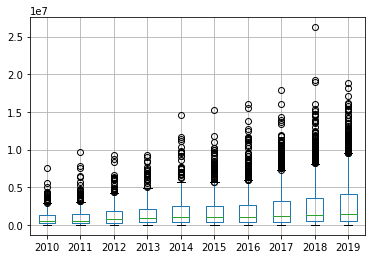

In [664]:
collectionEB.boxplot(showfliers=True)

In [668]:
collectionEB.loc[collectionEB['2019']>1.2e7]

2010       2011       2012       2013        2014  \
school                                                                  
南京理工大学图书馆      5598700.0  6512146.0  6397528.0  7091453.0         NaN   
电子科技大学图书馆      4971961.0  6330327.0  8322895.0        NaN  11073256.0   
西北工业大学图书馆      3748432.0  4207650.0  5513055.0  6379847.0   7079285.0   
中国科学技术大学图书馆    2500000.0        NaN        NaN  6850000.0   9121956.0   
清华大学图书馆        2384628.0  2461000.0  8707952.0        NaN  11719416.0   
集美大学图书馆        2145809.0  2353911.0        NaN  3169547.0   3437523.0   
苏州职业大学图书馆      1936430.0        NaN        NaN  5562367.0   6807928.0   
常州信息职业技术学院图书馆  1800000.0        NaN        NaN        NaN         NaN   
复旦大学图书馆        1639505.0  1958600.0  2102522.0  2339311.0   2492323.0   
武汉理工大学图书馆      1614319.0  1640950.0        NaN  9066909.0   9625689.0   
东南大学图书馆        1405087.0        NaN  1736151.0  1758563.0   7004114.0   
成都理工大学图书馆      1242499.0  2702758.0        NaN  6776439.0   7494581.0   
华中农业大学图书馆      1136337.0   900000.0        NaN        NaN         NaN   
南京林业大学图书馆       604017.0   670284.0        NaN  2633387.0         NaN   
西藏民族大学图书馆       494591.0   494591.0   494591.0   622000.0    640000.0   
沧州医学高等专科学校图书馆   188913.0        NaN        NaN   214173.0         NaN   
西南交通大学图书馆            NaN  7538954.0  6674010.0  7673002.0   9770254.0   
同济大学图书馆              NaN  3253105.0        NaN  3508078.0   3516407.0   
江南大学图书馆              NaN  2429994.0        NaN  3279920.0   8653121.0   
湖北工业大学图书馆            NaN  1799216.0  2053556.0        NaN         NaN   
广西大学图书馆              NaN  1730923.0  1742535.0  1746994.0         NaN   
中国民航大学图书馆            NaN  1430000.0  1650000.0  1854000.0         NaN   
山西医科大学图书馆            NaN   451523.0        NaN        NaN         NaN   
江汉大学图书馆              NaN    80000.0        NaN        NaN         NaN   
中央财经大学图书馆            NaN        NaN  3160000.0        NaN  10406126.0   
四川大学图书馆              NaN        NaN  2285356.0  2429090.0   2488754.0   
华北理工大学图书馆            NaN        NaN        NaN   287013.0         NaN   
辽宁科技大学图书馆            NaN        NaN        NaN        NaN   3987902.0   
哈尔滨工程大学图书馆           NaN        NaN        NaN        NaN    949722.0   
兰州理工大学图书馆            NaN        NaN        NaN        NaN         NaN   
长春师范大学图书馆            NaN        NaN        NaN        NaN         NaN   
北京航空航天大学图书馆          NaN        NaN        NaN        NaN         NaN   

                     2015        2016        2017        2018        2019  
school                                                                     
南京理工大学图书馆       1088650.0   7208803.0  10142902.0  15428619.0  15338058.0  
电子科技大学图书馆      11070411.0  13794086.0  13610686.0  14587570.0  15768143.0  
西北工业大学图书馆       7463039.0   8226753.0   9660829.0  12453081.0  13502888.0  
中国科学技术大学图书馆     9907210.0  10600000.0  11290000.0  13531577.0  14584789.0  
清华大学图书馆        11856097.0  12400882.0   8848499.0  26234800.0  18899900.0  
集美大学图书馆         3709638.0   6808761.0  10815386.0  11617234.0  12911092.0  
苏州职业大学图书馆       7350149.0   7877213.0   8340273.0  10077703.0  15448469.0  
常州信息职业技术学院图书馆   1660000.0         NaN   1881551.0         NaN  13094501.0  
复旦大学图书馆         2631037.0  10185262.0  11285964.0  13653994.0  15260645.0  
武汉理工大学图书馆      10238549.0  12726455.0  14325454.0  14410691.0  16131668.0  
东南大学图书馆         7662171.0  11218263.0   9455052.0   9567150.0  14641200.0  
成都理工大学图书馆       8352523.0   9560667.0  10390601.0  11299456.0  12296632.0  
华中农业大学图书馆             NaN   1035500.0   8048000.0         NaN  12712884.0  
南京林业大学图书馆             NaN         NaN  13406694.0   8793826.0  15054994.0  
西藏民族大学图书馆       3670000.0   4871000.0   5652042.0   5295455.0  13844882.0  
沧州医学高等专科学校图书馆         NaN         NaN         NaN         NaN  12128111.0  
西南交通大学图书馆       9610301.0  11509212.0  11887611.0  13850817.0  12565753.0  
同济大学图书馆         3525137.0   3544617.0  13905326.0  15129166.0  17120552.0  
江南大学图书馆         9

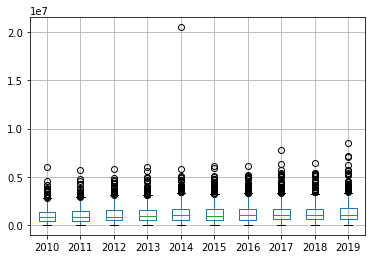

In [670]:
collectionPB.boxplot()

In [673]:
collectionPB.loc[collectionPB['2017']>0.5e7]

2010       2011       2012       2013       2014       2015  \
school                                                                       
南京大学图书馆   6053242.0  4507739.0  4610919.0        NaN  4837985.0  4928684.0   
中山大学图书馆   4555448.0  4713908.0  4819279.0  4944153.0  5087398.0  4400274.0   
浙江大学图书馆   3880431.0  4208302.0  4352143.0  4465051.0  4641087.0  4785200.0   
郑州大学图书馆   3370663.0  3447421.0        NaN  4891597.0  4974459.0  5056940.0   
河南大学图书馆   2617827.0        NaN        NaN  2988000.0        NaN  3667448.0   
承德医学院图书馆   562918.0        NaN        NaN   690000.0        NaN        NaN   
武汉大学图书馆         NaN  5675933.0  5771408.0  5629588.0  5817987.0  5929213.0   
四川大学图书馆         NaN        NaN  4513700.0  4610168.0  4702474.0  4790280.0   
吉林大学图书馆         NaN        NaN        NaN        NaN        NaN        NaN   

               2016       2017       2018       2019  
school                                                
南京大学图书馆   5044067.0  5129358.0        NaN  6208056.0  
中山大学图书馆   4735124.0  5055225.0  5397157.0  5663179.0  
浙江大学图书馆   4960705.0  5099047.0  5232337.0  5358238.0  
郑州大学图书馆         NaN  6341997.0  6413406.0        NaN  
河南大学图书馆   3989370.0  5398353.0        NaN        NaN  
承德医学院图书馆        NaN  7795958.0        NaN   769399.0  
武汉大学图书馆   6067083.0  5307399.0  5425950.0  5602070.0  
四川大学图书馆   4913356.0  5029143.0  5100562.0  5208207.0  
吉林大学图书馆         NaN  5744500.0        NaN        NaN

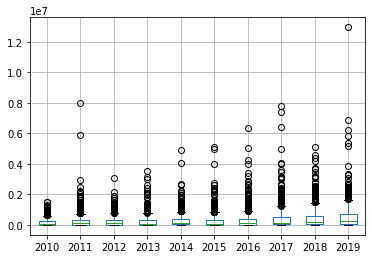

In [674]:
collectionEJ.boxplot()

In [677]:
collectionEJ.loc[collectionEJ['2011']>0.11e7]

2010       2011       2012       2013       2014  \
school                                                                 
西安交通大学图书馆      1288060.0  1837691.0  1912721.0  1128614.0  1310271.0   
沈阳工业大学图书馆      1235738.0  1289408.0        NaN   884560.0   940000.0   
西南财经大学图书馆      1200000.0  2200000.0        NaN  2600000.0  2634800.0   
上海应用技术大学图书馆     967297.0  1846922.0        NaN        NaN        NaN   
中南财经政法大学图书馆     900545.0  1380545.0   612862.0        NaN        NaN   
武汉大学图书馆         838207.0  1759053.0  1001424.0   912881.0  1295059.0   
河南工业大学图书馆       330014.0  2160000.0        NaN        NaN        NaN   
重庆交通大学图书馆       290581.0  1761017.0        NaN        NaN        NaN   
重庆大学图书馆          41850.0  5918625.0        NaN    89700.0    89700.0   
黎明职业大学图书馆        25000.0  1866285.0        NaN        NaN        NaN   
重庆理工大学图书馆            NaN  8000000.0        NaN        NaN        NaN   
西南林业大学图书馆            NaN  2938826.0        NaN        NaN        NaN   
淮南师范学院图书馆            NaN  2455137.0        NaN   270000.0   317900.0   
江苏师范大学图书馆            NaN  2137278.0  2165628.0  2194934.0  2230890.0   
温州科技职业学院图书馆          NaN  2029243.0        NaN        NaN   453184.0   
台州学院图书馆              NaN  1628082.0  1653113.0  1946226.0  1972226.0   
武汉铁路职业技术学院图书馆        NaN  1610000.0        NaN        NaN        NaN   
上海思博职业技术学院图书馆        NaN  1502508.0        NaN        NaN        NaN   
广西科技大学图书馆            NaN  1318830.0        NaN  2387870.0    24429.0   
北京工业大学图书馆            NaN  1269707.0  1200798.0  1250291.0  1389899.0   
上海交通大学图书馆            NaN  1176710.0  1274062.0  1387623.0  1417758.0   
浙江医药高等专科学校图书馆        NaN  1129760.0        NaN        NaN        NaN   
同济大学图书馆              NaN  1113494.0        NaN  1233847.0  1318931.0   

                    2015       2016       2017       2018       2019  
school                                                                
西安交通大学图书馆      2186164.0  2854650.0  2356242.0  3120230.0  3264912.0  
沈阳工业大学图书馆       140000.0  1026000.0  1074000.0  1122000.0   976500.0  
西南财经大学图书馆      2634800.0  2634800.0  2637518.0   391204.0   391186.0  
上海应用技术大学图书馆          NaN  2028510.0  2028510.0  2028510.0  2028510.0  
中南财经政法大学图书馆          NaN  2005232.0  1816733.0  2558129.0  2118393.0  
武汉大学图书馆        1459863.0  1623124.0  1859176.0  2046880.0  2068389.0  
河南工业大学图书馆        38436.0    38346.0    45941.0        NaN        NaN  
重庆交通大学图书馆            NaN        NaN        NaN        NaN        NaN  
重庆大学图书馆          90800.0    90800.0    90900.0    92100.0    92100.0  
黎明职业大学图书馆       450000.0   470000.0        NaN   490000.0        NaN  
重庆理工大学图书馆            NaN        NaN        NaN   110000.0        NaN  
西南林业大学图书馆            NaN    35948.0   277027.0        NaN        NaN  
淮南师范学院图书馆       297013.0        NaN   747300.0   776300.0   822000.0  
江苏师范大学图书馆      2272890.0   223994.0   947916.0  1272625.0   856740.0  
温州科技职业学院图书馆     498501.0   498501.0   527107.0   457842.0        NaN  
台州学院图书馆        1997257.0  2029439.0  2061621.0  2093803.0  2152571.0  
武汉铁路职业技术学院图书馆        NaN   150000.0        NaN   412500.0   427500.0  
上海思博职业技术学院图书馆        NaN   776145.0   831617.0   902149.0   902149.0  
广西科技大学图书馆        30003.0   325860.0   356704.0   387548.0   583024.0  
北京工业大学图书馆      1526047.0  1663180.0        NaN  1795371.0        NaN  
上海交通大学图书馆      1447327.0  1631527.0  1820515.0  2011580.0  2202675.0  
浙江医药高等专科学校图书馆  1156469.0   131946.0  1210903.0        NaN  1211038.0  
同济大学图书馆        1404213.0  1515334.0  1579463.0  1672373.0  1751002.0

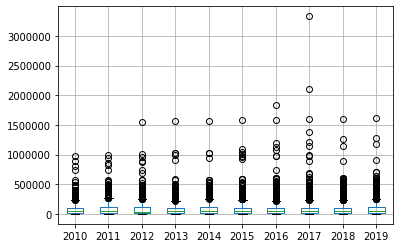

In [28]:
collectionPJ.boxplot()

In [50]:
collectionPJ.loc[collectionPJ['2014']<1000]

2010    2011    2012     2013   2014    2015  \
school                                                                    
黔南民族师范学院图书馆             68549.0     NaN     NaN    645.0  800.0   571.0   
上海公安学院图书馆               10476.0     NaN     NaN  10922.0  716.0   716.0   
西安音乐学院图书馆                5127.0  5000.0  6025.0      NaN  325.0   316.0   
福州英华职业学院图书馆              4098.0     NaN  3550.0   3880.0  950.0   308.0   
延安职业技术学院图书馆                 NaN   400.0   400.0      NaN  400.0   400.0   
厦门安防科技职业学院图书馆               NaN   260.0   300.0    350.0  350.0   402.0   
天津轻工职业技术学院图书馆               NaN     NaN  2691.0      NaN  165.0     NaN   
武夷山职业学院图书馆                  NaN     NaN   216.0    300.0  400.0   400.0   
山东商务职业学院图书馆                 NaN     NaN   200.0    200.0   50.0     NaN   
镇江市高等专科学校图书馆                NaN     NaN    21.0      NaN  673.0   300.0   
广东女子职业技术学院图书馆               NaN     NaN     NaN  20000.0  598.0   654.0   
南方科技大学图书馆                   NaN     NaN     NaN    945.0  945.0  1954.0   
中山火炬职业技术学院图书馆               NaN     NaN     NaN      NaN  894.0  3917.0   
广东创新科技职业学院图书馆               NaN     NaN     NaN      NaN  794.0  2067.0   
西安医学高等专科学校图书馆               NaN     NaN     NaN      NaN  644.0     NaN   
三明医学科技职业学院图书馆               NaN     NaN     NaN      NaN  300.0   500.0   
重庆电信职业学院图书馆                 NaN     NaN     NaN      NaN  246.0     NaN   
齐齐哈尔工程学院图书馆                 NaN     NaN     NaN      NaN  169.0     NaN   
北京师范大学-香港浸会大学联合国际学院图书馆      NaN     NaN     NaN      NaN   59.0   156.0   

                           2016     2017     2018     2019  
school                                                      
黔南民族师范学院图书馆                34.0  73685.0  74256.0  75073.0  
上海公安学院图书馆                1499.0   1728.0      NaN      NaN  
西安音乐学院图书馆                6107.0   6107.0      NaN      NaN  
福州英华职业学院图书馆               305.0      NaN    246.0     13.0  
延安职业技术学院图书馆               396.0      NaN   1249.0   1610.0  
厦门安防科技职业学院图书馆             466.0      NaN      NaN      NaN  
天津轻工职业技术学院图书馆               NaN      NaN      NaN      NaN  
武夷山职业学院图书馆                400.0      NaN      NaN     85.0  
山东商务职业学院图书馆                 NaN      NaN      NaN      NaN  
镇江市高等专科学校图书馆                NaN      NaN      NaN      NaN  
广东女子职业技术学院图书馆           20000.0  15200.0  15000.0      NaN  
南方科技大学图书馆                2487.0   2678.0   2678.0   3044.0  
中山火炬职业技术学院图书馆               NaN   3862.0  35303.0  35303.0  
广东创新科技职业学院图书馆            1720.0   3895.0   3856.0      NaN  
西安医学高等专科学校图书馆               NaN      NaN      NaN      NaN  
三明医学科技职业学院图书馆            1377.0   1577.0    300.0   5778.0  
重庆电信职业学院图书馆                 NaN      NaN      NaN      NaN  
齐齐哈尔工程学院图书馆                 NaN      NaN      NaN      NaN  
北京师范大学-香港浸会大学联合国际学院图书馆    156.0    156.0    494.0    599.0

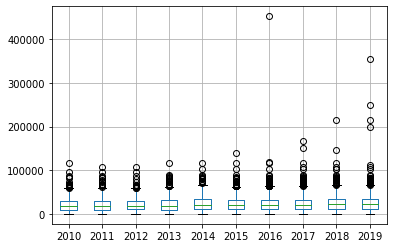

In [51]:
floor.boxplot()

In [56]:
floor.loc[floor['2019']>0.82e5]

2010           2011           2012           2013  \
school                                                                 
中山大学图书馆        116660.0  107000.000000  107000.000000  116660.000000   
浙江大学图书馆         86376.0   86376.000000   86376.000000   86376.000000   
厦门大学图书馆         67221.0   66868.000000   66868.000000   73482.000000   
山东大学图书馆         45344.0            NaN   64547.000000            NaN   
贵州大学图书馆         42190.0   39157.000000   31964.000000   89341.000000   
延安大学图书馆         36448.0   36448.000000   36448.000000   36448.000000   
合肥工业大学图书馆           NaN   50353.910156   50353.910156   50353.910156   
广东药科大学图书馆           NaN            NaN            NaN   54641.000000   
青岛港湾职业技术学院图书馆       NaN            NaN            NaN            NaN   
吉林铁道职业技术学院图书馆       NaN            NaN            NaN            NaN   
四川国际标榜职业学院图书馆       NaN            NaN            NaN            NaN   
杭州师范大学钱江学院图书馆       NaN            NaN            NaN            NaN   

                        2014           2015           2016           2017  \
school                                                                      
中山大学图书馆        116660.000000  116660.000000  116660.000000  116660.000000   
浙江大学图书馆         86376.000000            NaN   86376.000000   86376.000000   
厦门大学图书馆        102558.000000  102558.000000  102858.000000  102858.000000   
山东大学图书馆                  NaN   65060.000000   67060.000000  107060.000000   
贵州大学图书馆         89341.000000   89341.000000   82628.000000   88339.000000   
延安大学图书馆         36448.000000   36448.000000   36448.000000   36448.000000   
合肥工业大学图书馆       50353.429688   50353.910156   45001.429688   82614.226562   
广东药科大学图书馆       54641.000000   54641.000000   54641.000000   54641.000000   
青岛港湾职业技术学院图书馆   35000.000000            NaN            NaN            NaN   
吉林铁道职业技术学院图书馆            NaN            NaN   21600.000000   21600.000000   
四川国际标榜职业学院图书馆            NaN            NaN            NaN   20000.000000   
杭州师范大学钱江学院图书馆            NaN            NaN            NaN            NaN   

                        2018           2019  
school                                       
中山大学图书馆        116660.000000  111660.000000  
浙江大学图书馆         86376.000000   86376.000000  
厦门大学图书馆        102858.000000  102596.000000  
山东大学图书馆        107060.000000  107498.000000  
贵州大学图书馆         88339.000000   88339.000000  
延安大学图书馆         36448.000000   83000.000000  
合肥工业大学图书馆       82614.226562   82614.226562  
广东药科大学图书馆       82641.000000   82641.000000  
青岛港湾职业技术学院图书馆            NaN  250000.000000  
吉林铁道职业技术学院图书馆  216000.000000  216000.000000  
四川国际标榜职业学院图书馆   20000.000000  200000.000000  
杭州师范大学钱江学院图书馆            NaN  356000.000000

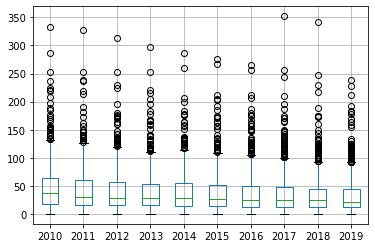

In [58]:
staffPermanent.boxplot()

In [60]:
staffPermanent.loc[staffPermanent['2019']>150]

2010   2011   2012   2013   2014   2015   2016   2017   2018  \
school                                                                     
武汉大学图书馆    332.0  328.0  313.0  298.0  286.0  275.0  265.0  256.0  247.0   
中山大学图书馆    286.0  252.0  252.0  253.0  259.0  267.0  257.0  243.0  229.0   
山东大学图书馆    252.0  236.0  224.0    NaN    NaN  202.0  206.0  195.0  188.0   
上海交通大学图书馆  237.0  238.0  230.0  220.0  207.0  212.0  211.0  210.0  217.0   
四川大学图书馆    225.0  219.0    NaN  204.0  199.0  192.0  187.0  186.0  174.0   
华中科技大学图书馆  220.0    NaN  196.0  195.0  183.0  185.0  179.0  174.0  172.0   
浙江大学图书馆    218.0  214.0  175.0  178.0  176.0    NaN  176.0  171.0  175.0   
复旦大学图书馆    198.0  191.0  180.0  184.0  178.0  164.0  168.0  171.0  175.0   
北京大学图书馆      NaN    NaN    NaN  215.0    NaN  204.0    NaN    NaN    NaN   
武汉理工大学图书馆  176.0    NaN  170.0  166.0  176.0  174.0  174.0  165.0  160.0   
厦门大学图书馆    172.0  172.0  170.0  168.0  164.0  164.0  162.0  164.0    NaN   

            2019  
school            
武汉大学图书馆    239.0  
中山大学图书馆    227.0  
山东大学图书馆    182.0  
上海交通大学图书馆  211.0  
四川大学图书馆    169.0  
华中科技大学图书馆  164.0  
浙江大学图书馆    183.0  
复旦大学图书馆    178.0  
北京大学图书馆    193.0  
武汉理工大学图书馆  159.0  
厦门大学图书馆    154.0

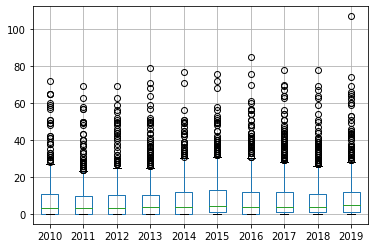

In [61]:
staffFixedTerm.boxplot()

In [62]:
staffFixedTerm.loc[staffFixedTerm['2013']>60]

2010  2011  2012  2013  2014  2015  2016  2017  2018  2019
school                                                               
西北民族大学图书馆  65.0   NaN   NaN  79.0  71.0  76.0  76.0  70.0   NaN   NaN
河北经贸大学图书馆  65.0  69.0   NaN  68.0   NaN   NaN   NaN   NaN   NaN  66.0
西南交通大学图书馆  60.0  63.0  69.0  71.0  77.0  72.0  70.0  67.0  64.0  64.0
北京大学图书馆     NaN   NaN   NaN  64.0   NaN  68.0   NaN   NaN   NaN   NaN

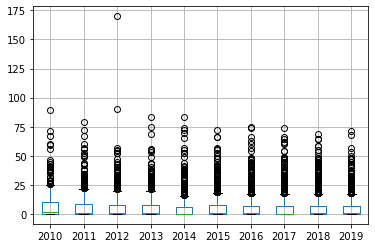

In [63]:
staffCasual.boxplot()

In [64]:
staffCasual.loc[staffCasual['2012']>50]

2010  2011   2012  2013  2014  2015  2016  2017  2018  2019
school                                                                    
浙江大学图书馆        71.0  72.0  170.0  83.0  83.0   NaN  75.0  74.0  69.0  71.0
陕西师范大学图书馆      60.0  60.0   55.0  55.0  55.0  55.0  57.0  62.0  64.0  68.0
华中科技大学图书馆      56.0   NaN   90.0   0.0  72.0  66.0  74.0  60.0  48.0  48.0
榆林学院图书馆        46.0  56.0   54.0   NaN  35.0  33.0  36.0  49.0  45.0  19.0
重庆大学图书馆        45.0   NaN   52.0  53.0  52.0  20.0  21.0  61.0  58.0  17.0
长安大学图书馆        43.0  52.0   52.0   NaN  52.0  52.0  45.0  54.0  53.0  50.0
上海立信会计金融学院图书馆   NaN  57.0   57.0  56.0   NaN  56.0   NaN   NaN   NaN   NaN

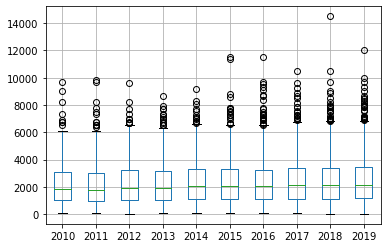

In [65]:
seats.boxplot()

In [66]:
seats.loc[seats['2019']>10000]

2010  2011  2012  2013  2014  2015    2016    2017    2018     2019
school                                                                        
江西农业大学图书馆   NaN   NaN   NaN   NaN   NaN   NaN  4100.0  6100.0  5100.0  12066.0

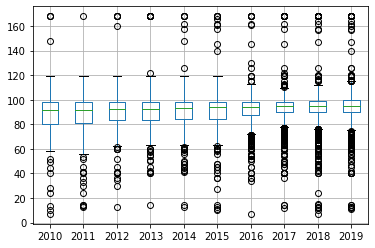

In [67]:
hours.boxplot()

In [79]:
hours.loc[hours['2019']>168]

Empty DataFrame
Columns: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
Index: []

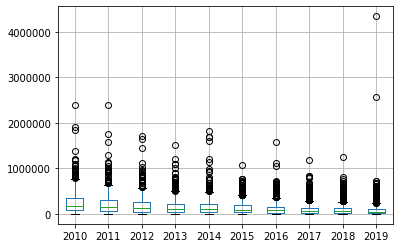

In [80]:
loan.boxplot()

In [93]:
loan.loc[loan['2016']>1e6]

2010       2011       2012       2013       2014       2015  \
school                                                                        
四川大学图书馆    2396243.0        NaN  1710000.0   700754.0  1820000.0        NaN   
武汉大学图书馆    1065522.0  1763515.0  1652354.0  1517868.0  1141251.0  1073588.0   
山西财经大学图书馆        NaN    84150.0        NaN        NaN        NaN        NaN   

                2016       2017       2018      2019  
school                                                
四川大学图书馆    1570096.0   841047.0   777785.0  731706.0  
武汉大学图书馆    1111985.0  1179015.0  1253180.0  655586.0  
山西财经大学图书馆  1061887.0    87465.0        NaN  114716.0

In [100]:
loan.iloc[1].

AttributeError: 'Series' object has no attribute 'Name'

In [106]:
sTb=1/2

for index, row in loan.iterrows():
    for x in [i for i in row if i is not np.nan]:
        for y in range(0, len([i for i in row if i is not np.nan])-1):
            if y <= sTb * (y+1):
                print(index)
#                 print(loan.iloc[index])
#     print(row[0]) # 输出每行的索引值

四川大学图书馆
四川大学图书馆
四川大学图书馆
四川大学图书馆
四川大学图书馆
四川大学图书馆
四川大学图书馆
四川大学图书馆
四川大学图书馆
四川大学图书馆
四川大学图书馆
四川大学图书馆
四川大学图书馆
四川大学图书馆
四川大学图书馆
四川大学图书馆
四川大学图书馆
四川大学图书馆
四川大学图书馆
四川大学图书馆
中南大学图书馆
中南大学图书馆
中南大学图书馆
中南大学图书馆
中南大学图书馆
中南大学图书馆
中南大学图书馆
中南大学图书馆
中南大学图书馆
中南大学图书馆
中南大学图书馆
中南大学图书馆
中南大学图书馆
中南大学图书馆
中南大学图书馆
中南大学图书馆
中南大学图书馆
中南大学图书馆
中南大学图书馆
中南大学图书馆
山东大学图书馆
山东大学图书馆
山东大学图书馆
山东大学图书馆
山东大学图书馆
山东大学图书馆
山东大学图书馆
山东大学图书馆
山东大学图书馆
山东大学图书馆
山东大学图书馆
山东大学图书馆
山东大学图书馆
山东大学图书馆
山东大学图书馆
山东大学图书馆
山东大学图书馆
山东大学图书馆
山东大学图书馆
山东大学图书馆
厦门大学图书馆
厦门大学图书馆
厦门大学图书馆
厦门大学图书馆
厦门大学图书馆
厦门大学图书馆
厦门大学图书馆
厦门大学图书馆
厦门大学图书馆
厦门大学图书馆
厦门大学图书馆
厦门大学图书馆
厦门大学图书馆
厦门大学图书馆
厦门大学图书馆
厦门大学图书馆
厦门大学图书馆
厦门大学图书馆
厦门大学图书馆
厦门大学图书馆
沈阳师范大学图书馆
沈阳师范大学图书馆
沈阳师范大学图书馆
沈阳师范大学图书馆
沈阳师范大学图书馆
沈阳师范大学图书馆
沈阳师范大学图书馆
沈阳师范大学图书馆
沈阳师范大学图书馆
沈阳师范大学图书馆
沈阳师范大学图书馆
沈阳师范大学图书馆
沈阳师范大学图书馆
沈阳师范大学图书馆
沈阳师范大学图书馆
沈阳师范大学图书馆
沈阳师范大学图书馆
沈阳师范大学图书馆
沈阳师范大学图书馆
沈阳师范大学图书馆
湖南大学图书馆
湖南大学图书馆
湖南大学图书馆
湖南大学图书馆
湖南大学图书馆
湖南大学图书馆
湖南大学图书馆
湖南大学图书馆
湖南大学图书馆
湖南大学图书馆
湖南大学图书馆
湖南大学图书馆
湖南大学图书馆
湖南大学图书馆
湖南大学图书馆
湖南大学图书馆
湖南大学图书馆
湖南大学图书馆
湖南大学图书馆
湖南大学图书馆


中国计量大学图书馆
中国计量大学图书馆
中国计量大学图书馆
中国计量大学图书馆
中国计量大学图书馆
中国计量大学图书馆
中国计量大学图书馆
中国计量大学图书馆
中国计量大学图书馆
河北师范大学图书馆
河北师范大学图书馆
河北师范大学图书馆
河北师范大学图书馆
河北师范大学图书馆
河北师范大学图书馆
河北师范大学图书馆
河北师范大学图书馆
河北师范大学图书馆
河北师范大学图书馆
河北师范大学图书馆
河北师范大学图书馆
河北师范大学图书馆
河北师范大学图书馆
河北师范大学图书馆
河北师范大学图书馆
河北师范大学图书馆
河北师范大学图书馆
河北师范大学图书馆
河北师范大学图书馆
西北民族大学图书馆
西北民族大学图书馆
西北民族大学图书馆
西北民族大学图书馆
西北民族大学图书馆
西北民族大学图书馆
西北民族大学图书馆
西北民族大学图书馆
西北民族大学图书馆
西北民族大学图书馆
西北民族大学图书馆
西北民族大学图书馆
西北民族大学图书馆
西北民族大学图书馆
西北民族大学图书馆
西北民族大学图书馆
西北民族大学图书馆
西北民族大学图书馆
西北民族大学图书馆
西北民族大学图书馆
汉口学院图书馆
汉口学院图书馆
汉口学院图书馆
汉口学院图书馆
汉口学院图书馆
汉口学院图书馆
汉口学院图书馆
汉口学院图书馆
汉口学院图书馆
汉口学院图书馆
汉口学院图书馆
汉口学院图书馆
汉口学院图书馆
汉口学院图书馆
汉口学院图书馆
汉口学院图书馆
汉口学院图书馆
汉口学院图书馆
汉口学院图书馆
汉口学院图书馆
西北师范大学图书馆
西北师范大学图书馆
西北师范大学图书馆
西北师范大学图书馆
西北师范大学图书馆
西北师范大学图书馆
西北师范大学图书馆
西北师范大学图书馆
西北师范大学图书馆
西北师范大学图书馆
西北师范大学图书馆
西北师范大学图书馆
西北师范大学图书馆
西北师范大学图书馆
西北师范大学图书馆
西北师范大学图书馆
西北师范大学图书馆
西北师范大学图书馆
西北师范大学图书馆
西北师范大学图书馆
北京林业大学图书馆
北京林业大学图书馆
北京林业大学图书馆
北京林业大学图书馆
北京林业大学图书馆
北京林业大学图书馆
北京林业大学图书馆
北京林业大学图书馆
北京林业大学图书馆
北京林业大学图书馆
北京林业大学图书馆
北京林业大学图书馆
北京林业大学图书馆
北京林业大学图书馆
北京林业大学图书馆


对外经济贸易大学图书馆
对外经济贸易大学图书馆
对外经济贸易大学图书馆
对外经济贸易大学图书馆
对外经济贸易大学图书馆
对外经济贸易大学图书馆
对外经济贸易大学图书馆
对外经济贸易大学图书馆
对外经济贸易大学图书馆
对外经济贸易大学图书馆
山西大学图书馆
山西大学图书馆
山西大学图书馆
山西大学图书馆
山西大学图书馆
山西大学图书馆
山西大学图书馆
山西大学图书馆
山西大学图书馆
山西大学图书馆
山西大学图书馆
山西大学图书馆
山西大学图书馆
山西大学图书馆
山西大学图书馆
山西大学图书馆
山西大学图书馆
山西大学图书馆
山西大学图书馆
山西大学图书馆
延安大学图书馆
延安大学图书馆
延安大学图书馆
延安大学图书馆
延安大学图书馆
延安大学图书馆
延安大学图书馆
延安大学图书馆
延安大学图书馆
延安大学图书馆
延安大学图书馆
延安大学图书馆
延安大学图书馆
延安大学图书馆
延安大学图书馆
延安大学图书馆
延安大学图书馆
延安大学图书馆
延安大学图书馆
延安大学图书馆
上海海事大学图书馆
上海海事大学图书馆
上海海事大学图书馆
上海海事大学图书馆
上海海事大学图书馆
上海海事大学图书馆
上海海事大学图书馆
上海海事大学图书馆
上海海事大学图书馆
上海海事大学图书馆
上海海事大学图书馆
上海海事大学图书馆
上海海事大学图书馆
上海海事大学图书馆
上海海事大学图书馆
上海海事大学图书馆
上海海事大学图书馆
上海海事大学图书馆
上海海事大学图书馆
上海海事大学图书馆
武汉纺织大学图书馆
武汉纺织大学图书馆
武汉纺织大学图书馆
武汉纺织大学图书馆
武汉纺织大学图书馆
武汉纺织大学图书馆
武汉纺织大学图书馆
武汉纺织大学图书馆
武汉纺织大学图书馆
武汉纺织大学图书馆
武汉纺织大学图书馆
武汉纺织大学图书馆
武汉纺织大学图书馆
武汉纺织大学图书馆
武汉纺织大学图书馆
武汉纺织大学图书馆
武汉纺织大学图书馆
武汉纺织大学图书馆
武汉纺织大学图书馆
武汉纺织大学图书馆
石家庄铁道大学图书馆
石家庄铁道大学图书馆
石家庄铁道大学图书馆
石家庄铁道大学图书馆
石家庄铁道大学图书馆
石家庄铁道大学图书馆
石家庄铁道大学图书馆
石家庄铁道大学图书馆
石家庄铁道大学图书馆
石家庄铁道大学图书馆
石家庄铁道大学图书馆
石家庄铁道大学图书馆
石家庄铁道大学图书馆
石家庄铁道大学图书馆
石家庄铁道大

西南医科大学图书馆
西南医科大学图书馆
西南医科大学图书馆
西南医科大学图书馆
西南医科大学图书馆
西南医科大学图书馆
西南医科大学图书馆
西南医科大学图书馆
西南医科大学图书馆
西南医科大学图书馆
温州医科大学图书馆
温州医科大学图书馆
温州医科大学图书馆
温州医科大学图书馆
温州医科大学图书馆
温州医科大学图书馆
温州医科大学图书馆
温州医科大学图书馆
温州医科大学图书馆
温州医科大学图书馆
温州医科大学图书馆
温州医科大学图书馆
温州医科大学图书馆
温州医科大学图书馆
温州医科大学图书馆
温州医科大学图书馆
温州医科大学图书馆
温州医科大学图书馆
温州医科大学图书馆
温州医科大学图书馆
浙江万里学院图书馆
浙江万里学院图书馆
浙江万里学院图书馆
浙江万里学院图书馆
浙江万里学院图书馆
浙江万里学院图书馆
浙江万里学院图书馆
浙江万里学院图书馆
浙江万里学院图书馆
浙江万里学院图书馆
浙江万里学院图书馆
浙江万里学院图书馆
浙江万里学院图书馆
浙江万里学院图书馆
浙江万里学院图书馆
浙江万里学院图书馆
浙江万里学院图书馆
浙江万里学院图书馆
浙江万里学院图书馆
浙江万里学院图书馆
镇江市高等专科学校图书馆
镇江市高等专科学校图书馆
镇江市高等专科学校图书馆
镇江市高等专科学校图书馆
镇江市高等专科学校图书馆
镇江市高等专科学校图书馆
镇江市高等专科学校图书馆
镇江市高等专科学校图书馆
镇江市高等专科学校图书馆
镇江市高等专科学校图书馆
镇江市高等专科学校图书馆
镇江市高等专科学校图书馆
镇江市高等专科学校图书馆
镇江市高等专科学校图书馆
镇江市高等专科学校图书馆
镇江市高等专科学校图书馆
镇江市高等专科学校图书馆
镇江市高等专科学校图书馆
镇江市高等专科学校图书馆
镇江市高等专科学校图书馆
长沙学院图书馆
长沙学院图书馆
长沙学院图书馆
长沙学院图书馆
长沙学院图书馆
长沙学院图书馆
长沙学院图书馆
长沙学院图书馆
长沙学院图书馆
长沙学院图书馆
长沙学院图书馆
长沙学院图书馆
长沙学院图书馆
长沙学院图书馆
长沙学院图书馆
长沙学院图书馆
长沙学院图书馆
长沙学院图书馆
长沙学院图书馆
长沙学院图书馆
中国医科大学图书馆
中国医科大学图书馆
中国医科大学图书馆
中国医科大学图书馆
中国医科大学图书馆
中国医科大学图书馆
中国医科大学图书馆
中国医科大学图书馆


上海音乐学院图书馆
上海音乐学院图书馆
上海音乐学院图书馆
上海音乐学院图书馆
上海音乐学院图书馆
上海音乐学院图书馆
上海音乐学院图书馆
上海音乐学院图书馆
上海音乐学院图书馆
上海音乐学院图书馆
上海音乐学院图书馆
上海音乐学院图书馆
上海音乐学院图书馆
上海音乐学院图书馆
无锡职业技术学院图书馆
无锡职业技术学院图书馆
无锡职业技术学院图书馆
无锡职业技术学院图书馆
无锡职业技术学院图书馆
无锡职业技术学院图书馆
无锡职业技术学院图书馆
无锡职业技术学院图书馆
无锡职业技术学院图书馆
无锡职业技术学院图书馆
无锡职业技术学院图书馆
无锡职业技术学院图书馆
无锡职业技术学院图书馆
无锡职业技术学院图书馆
无锡职业技术学院图书馆
无锡职业技术学院图书馆
无锡职业技术学院图书馆
无锡职业技术学院图书馆
无锡职业技术学院图书馆
无锡职业技术学院图书馆
南通职业大学图书馆
南通职业大学图书馆
南通职业大学图书馆
南通职业大学图书馆
南通职业大学图书馆
南通职业大学图书馆
南通职业大学图书馆
南通职业大学图书馆
南通职业大学图书馆
南通职业大学图书馆
南通职业大学图书馆
南通职业大学图书馆
南通职业大学图书馆
南通职业大学图书馆
南通职业大学图书馆
南通职业大学图书馆
南通职业大学图书馆
南通职业大学图书馆
南通职业大学图书馆
南通职业大学图书馆
大连职业技术学院图书馆
大连职业技术学院图书馆
大连职业技术学院图书馆
大连职业技术学院图书馆
大连职业技术学院图书馆
大连职业技术学院图书馆
大连职业技术学院图书馆
大连职业技术学院图书馆
大连职业技术学院图书馆
大连职业技术学院图书馆
大连职业技术学院图书馆
大连职业技术学院图书馆
大连职业技术学院图书馆
大连职业技术学院图书馆
大连职业技术学院图书馆
大连职业技术学院图书馆
大连职业技术学院图书馆
大连职业技术学院图书馆
大连职业技术学院图书馆
大连职业技术学院图书馆
贵州中医药大学图书馆
贵州中医药大学图书馆
贵州中医药大学图书馆
贵州中医药大学图书馆
贵州中医药大学图书馆
贵州中医药大学图书馆
贵州中医药大学图书馆
贵州中医药大学图书馆
贵州中医药大学图书馆
贵州中医药大学图书馆
贵州中医药大学图书馆
贵州中医药大学图书馆
贵州中医药大学图书馆
贵州中医药大学图书馆
贵州中医药大学图书馆
贵州中医药大学图书馆
贵州中医

浙江广厦建设职业技术学院图书馆
浙江广厦建设职业技术学院图书馆
浙江广厦建设职业技术学院图书馆
浙江广厦建设职业技术学院图书馆
浙江广厦建设职业技术学院图书馆
浙江广厦建设职业技术学院图书馆
浙江广厦建设职业技术学院图书馆
浙江广厦建设职业技术学院图书馆
浙江广厦建设职业技术学院图书馆
浙江广厦建设职业技术学院图书馆
浙江广厦建设职业技术学院图书馆
厦门海洋职业技术学院图书馆
厦门海洋职业技术学院图书馆
厦门海洋职业技术学院图书馆
厦门海洋职业技术学院图书馆
厦门海洋职业技术学院图书馆
厦门海洋职业技术学院图书馆
厦门海洋职业技术学院图书馆
厦门海洋职业技术学院图书馆
厦门海洋职业技术学院图书馆
厦门海洋职业技术学院图书馆
厦门海洋职业技术学院图书馆
厦门海洋职业技术学院图书馆
厦门海洋职业技术学院图书馆
厦门海洋职业技术学院图书馆
厦门海洋职业技术学院图书馆
厦门海洋职业技术学院图书馆
厦门海洋职业技术学院图书馆
厦门海洋职业技术学院图书馆
厦门海洋职业技术学院图书馆
厦门海洋职业技术学院图书馆
南京森林警察学院图书馆
南京森林警察学院图书馆
南京森林警察学院图书馆
南京森林警察学院图书馆
南京森林警察学院图书馆
南京森林警察学院图书馆
南京森林警察学院图书馆
南京森林警察学院图书馆
南京森林警察学院图书馆
南京森林警察学院图书馆
南京森林警察学院图书馆
南京森林警察学院图书馆
南京森林警察学院图书馆
南京森林警察学院图书馆
南京森林警察学院图书馆
南京森林警察学院图书馆
南京森林警察学院图书馆
南京森林警察学院图书馆
南京森林警察学院图书馆
南京森林警察学院图书馆
内江职业技术学院图书馆
内江职业技术学院图书馆
内江职业技术学院图书馆
内江职业技术学院图书馆
内江职业技术学院图书馆
内江职业技术学院图书馆
内江职业技术学院图书馆
内江职业技术学院图书馆
内江职业技术学院图书馆
内江职业技术学院图书馆
内江职业技术学院图书馆
内江职业技术学院图书馆
内江职业技术学院图书馆
内江职业技术学院图书馆
内江职业技术学院图书馆
内江职业技术学院图书馆
内江职业技术学院图书馆
内江职业技术学院图书馆
内江职业技术学院图书馆
内江职业技术学院图书馆
上海海关学院图书馆
上海海关学院图书馆
上海海关学院图书馆
上海海关学院图书馆
上海海关学院图书馆
上海海关学院图书馆
上海海关

江苏卫生健康职业学院图书馆
江苏卫生健康职业学院图书馆
江苏卫生健康职业学院图书馆
江苏卫生健康职业学院图书馆
江苏卫生健康职业学院图书馆
江苏卫生健康职业学院图书馆
江苏卫生健康职业学院图书馆
江苏卫生健康职业学院图书馆
江苏卫生健康职业学院图书馆
江苏卫生健康职业学院图书馆
江苏卫生健康职业学院图书馆
江苏卫生健康职业学院图书馆
沈阳音乐学院图书馆
沈阳音乐学院图书馆
沈阳音乐学院图书馆
沈阳音乐学院图书馆
沈阳音乐学院图书馆
沈阳音乐学院图书馆
沈阳音乐学院图书馆
沈阳音乐学院图书馆
沈阳音乐学院图书馆
沈阳音乐学院图书馆
沈阳音乐学院图书馆
沈阳音乐学院图书馆
沈阳音乐学院图书馆
沈阳音乐学院图书馆
沈阳音乐学院图书馆
沈阳音乐学院图书馆
沈阳音乐学院图书馆
沈阳音乐学院图书馆
沈阳音乐学院图书馆
沈阳音乐学院图书馆
河北石油职业技术学院图书馆
河北石油职业技术学院图书馆
河北石油职业技术学院图书馆
河北石油职业技术学院图书馆
河北石油职业技术学院图书馆
河北石油职业技术学院图书馆
河北石油职业技术学院图书馆
河北石油职业技术学院图书馆
河北石油职业技术学院图书馆
河北石油职业技术学院图书馆
河北石油职业技术学院图书馆
河北石油职业技术学院图书馆
河北石油职业技术学院图书馆
河北石油职业技术学院图书馆
河北石油职业技术学院图书馆
河北石油职业技术学院图书馆
河北石油职业技术学院图书馆
河北石油职业技术学院图书馆
河北石油职业技术学院图书馆
河北石油职业技术学院图书馆
上海电子信息职业技术学院图书馆
上海电子信息职业技术学院图书馆
上海电子信息职业技术学院图书馆
上海电子信息职业技术学院图书馆
上海电子信息职业技术学院图书馆
上海电子信息职业技术学院图书馆
上海电子信息职业技术学院图书馆
上海电子信息职业技术学院图书馆
上海电子信息职业技术学院图书馆
上海电子信息职业技术学院图书馆
上海电子信息职业技术学院图书馆
上海电子信息职业技术学院图书馆
上海电子信息职业技术学院图书馆
上海电子信息职业技术学院图书馆
上海电子信息职业技术学院图书馆
上海电子信息职业技术学院图书馆
上海电子信息职业技术学院图书馆
上海电子信息职业技术学院图书馆
上海电子信息职业技术学院图书馆
上海电子信息职业技术学院图书馆
渤海船舶职业学院图书馆
渤海船舶职业学院图书馆
渤海船舶职业学院

浙江科技学院图书馆
浙江科技学院图书馆
浙江科技学院图书馆
浙江科技学院图书馆
浙江科技学院图书馆
浙江科技学院图书馆
浙江科技学院图书馆
浙江科技学院图书馆
浙江科技学院图书馆
浙江科技学院图书馆
浙江科技学院图书馆
浙江科技学院图书馆
湖北汽车工业学院图书馆
湖北汽车工业学院图书馆
湖北汽车工业学院图书馆
湖北汽车工业学院图书馆
湖北汽车工业学院图书馆
湖北汽车工业学院图书馆
湖北汽车工业学院图书馆
湖北汽车工业学院图书馆
湖北汽车工业学院图书馆
湖北汽车工业学院图书馆
湖北汽车工业学院图书馆
湖北汽车工业学院图书馆
湖北汽车工业学院图书馆
湖北汽车工业学院图书馆
湖北汽车工业学院图书馆
湖北汽车工业学院图书馆
湖北汽车工业学院图书馆
湖北汽车工业学院图书馆
湖北汽车工业学院图书馆
湖北汽车工业学院图书馆
攀枝花学院图书馆
攀枝花学院图书馆
攀枝花学院图书馆
攀枝花学院图书馆
攀枝花学院图书馆
攀枝花学院图书馆
攀枝花学院图书馆
攀枝花学院图书馆
攀枝花学院图书馆
攀枝花学院图书馆
攀枝花学院图书馆
攀枝花学院图书馆
攀枝花学院图书馆
攀枝花学院图书馆
攀枝花学院图书馆
攀枝花学院图书馆
攀枝花学院图书馆
攀枝花学院图书馆
攀枝花学院图书馆
攀枝花学院图书馆
太原理工大学图书馆
太原理工大学图书馆
太原理工大学图书馆
太原理工大学图书馆
太原理工大学图书馆
太原理工大学图书馆
太原理工大学图书馆
太原理工大学图书馆
太原理工大学图书馆
太原理工大学图书馆
太原理工大学图书馆
太原理工大学图书馆
太原理工大学图书馆
太原理工大学图书馆
太原理工大学图书馆
太原理工大学图书馆
太原理工大学图书馆
太原理工大学图书馆
太原理工大学图书馆
太原理工大学图书馆
中国民航大学图书馆
中国民航大学图书馆
中国民航大学图书馆
中国民航大学图书馆
中国民航大学图书馆
中国民航大学图书馆
中国民航大学图书馆
中国民航大学图书馆
中国民航大学图书馆
中国民航大学图书馆
中国民航大学图书馆
中国民航大学图书馆
中国民航大学图书馆
中国民航大学图书馆
中国民航大学图书馆
中国民航大学图书馆
中国民航大学图书馆
中国民航大学图书馆
中国民航大学图书馆
中国民航大学图书馆
海南职业技术学院图书馆
海南职业技术学院图书馆
海南职业技术学院图书馆
海南职业技术学院图书馆
海南职业技术学院图书馆


湖州职业技术学院图书馆
湖州职业技术学院图书馆
湖州职业技术学院图书馆
湖州职业技术学院图书馆
湖州职业技术学院图书馆
湖州职业技术学院图书馆
湖州职业技术学院图书馆
湖州职业技术学院图书馆
湖州职业技术学院图书馆
湖州职业技术学院图书馆
湖州职业技术学院图书馆
湖州职业技术学院图书馆
湖州职业技术学院图书馆
湖北警官学院图书馆
湖北警官学院图书馆
湖北警官学院图书馆
湖北警官学院图书馆
湖北警官学院图书馆
湖北警官学院图书馆
湖北警官学院图书馆
湖北警官学院图书馆
湖北警官学院图书馆
湖北警官学院图书馆
湖北警官学院图书馆
湖北警官学院图书馆
湖北警官学院图书馆
湖北警官学院图书馆
湖北警官学院图书馆
湖北警官学院图书馆
湖北警官学院图书馆
湖北警官学院图书馆
湖北警官学院图书馆
湖北警官学院图书馆
福州理工学院图书馆
福州理工学院图书馆
福州理工学院图书馆
福州理工学院图书馆
福州理工学院图书馆
福州理工学院图书馆
福州理工学院图书馆
福州理工学院图书馆
福州理工学院图书馆
福州理工学院图书馆
福州理工学院图书馆
福州理工学院图书馆
福州理工学院图书馆
福州理工学院图书馆
福州理工学院图书馆
福州理工学院图书馆
福州理工学院图书馆
福州理工学院图书馆
福州理工学院图书馆
福州理工学院图书馆
海南软件职业技术学院图书馆
海南软件职业技术学院图书馆
海南软件职业技术学院图书馆
海南软件职业技术学院图书馆
海南软件职业技术学院图书馆
海南软件职业技术学院图书馆
海南软件职业技术学院图书馆
海南软件职业技术学院图书馆
海南软件职业技术学院图书馆
海南软件职业技术学院图书馆
海南软件职业技术学院图书馆
海南软件职业技术学院图书馆
海南软件职业技术学院图书馆
海南软件职业技术学院图书馆
海南软件职业技术学院图书馆
海南软件职业技术学院图书馆
海南软件职业技术学院图书馆
海南软件职业技术学院图书馆
海南软件职业技术学院图书馆
海南软件职业技术学院图书馆
天津现代职业技术学院图书馆
天津现代职业技术学院图书馆
天津现代职业技术学院图书馆
天津现代职业技术学院图书馆
天津现代职业技术学院图书馆
天津现代职业技术学院图书馆
天津现代职业技术学院图书馆
天津现代职业技术学院图书馆
天津现代职业技术学院图书馆
天津现代职业技术学院图书馆
天津现代职业技术学院图书馆
天津现代职业技术学院

青海民族大学图书馆
青海民族大学图书馆
青海民族大学图书馆
青海民族大学图书馆
青海民族大学图书馆
青海民族大学图书馆
青海民族大学图书馆
青海民族大学图书馆
青海民族大学图书馆
青海民族大学图书馆
青海民族大学图书馆
青海民族大学图书馆
青海民族大学图书馆
南开大学滨海学院图书馆
南开大学滨海学院图书馆
南开大学滨海学院图书馆
南开大学滨海学院图书馆
南开大学滨海学院图书馆
南开大学滨海学院图书馆
南开大学滨海学院图书馆
南开大学滨海学院图书馆
南开大学滨海学院图书馆
南开大学滨海学院图书馆
南开大学滨海学院图书馆
南开大学滨海学院图书馆
南开大学滨海学院图书馆
南开大学滨海学院图书馆
南开大学滨海学院图书馆
南开大学滨海学院图书馆
南开大学滨海学院图书馆
南开大学滨海学院图书馆
南开大学滨海学院图书馆
南开大学滨海学院图书馆
烟台南山学院图书馆
烟台南山学院图书馆
烟台南山学院图书馆
烟台南山学院图书馆
烟台南山学院图书馆
烟台南山学院图书馆
烟台南山学院图书馆
烟台南山学院图书馆
烟台南山学院图书馆
烟台南山学院图书馆
烟台南山学院图书馆
烟台南山学院图书馆
烟台南山学院图书馆
烟台南山学院图书馆
烟台南山学院图书馆
烟台南山学院图书馆
烟台南山学院图书馆
烟台南山学院图书馆
烟台南山学院图书馆
烟台南山学院图书馆
萍乡学院图书馆
萍乡学院图书馆
萍乡学院图书馆
萍乡学院图书馆
萍乡学院图书馆
萍乡学院图书馆
萍乡学院图书馆
萍乡学院图书馆
萍乡学院图书馆
萍乡学院图书馆
萍乡学院图书馆
萍乡学院图书馆
萍乡学院图书馆
萍乡学院图书馆
萍乡学院图书馆
萍乡学院图书馆
萍乡学院图书馆
萍乡学院图书馆
萍乡学院图书馆
萍乡学院图书馆
绵阳师范学院图书馆
绵阳师范学院图书馆
绵阳师范学院图书馆
绵阳师范学院图书馆
绵阳师范学院图书馆
绵阳师范学院图书馆
绵阳师范学院图书馆
绵阳师范学院图书馆
绵阳师范学院图书馆
绵阳师范学院图书馆
绵阳师范学院图书馆
绵阳师范学院图书馆
绵阳师范学院图书馆
绵阳师范学院图书馆
绵阳师范学院图书馆
绵阳师范学院图书馆
绵阳师范学院图书馆
绵阳师范学院图书馆
绵阳师范学院图书馆
绵阳师范学院图书馆
广西医科大学图书馆
广西医科大学图书馆
广西医科大学图书馆
广西医科大学图书馆
广西医科大学图书馆
广西医科大学图书馆
广西医科大学图书馆


河南农业大学图书馆
河南农业大学图书馆
河南农业大学图书馆
河南农业大学图书馆
河南农业大学图书馆
河南农业大学图书馆
河南农业大学图书馆
河南农业大学图书馆
河南农业大学图书馆
河南农业大学图书馆
河南农业大学图书馆
河南农业大学图书馆
河南农业大学图书馆
河南农业大学图书馆
河南农业大学图书馆
广东技术师范大学图书馆
广东技术师范大学图书馆
广东技术师范大学图书馆
广东技术师范大学图书馆
广东技术师范大学图书馆
广东技术师范大学图书馆
广东技术师范大学图书馆
广东技术师范大学图书馆
广东技术师范大学图书馆
广东技术师范大学图书馆
广东技术师范大学图书馆
广东技术师范大学图书馆
广东技术师范大学图书馆
广东技术师范大学图书馆
广东技术师范大学图书馆
广东技术师范大学图书馆
广东技术师范大学图书馆
广东技术师范大学图书馆
广东技术师范大学图书馆
广东技术师范大学图书馆
安徽工业大学图书馆
安徽工业大学图书馆
安徽工业大学图书馆
安徽工业大学图书馆
安徽工业大学图书馆
安徽工业大学图书馆
安徽工业大学图书馆
安徽工业大学图书馆
安徽工业大学图书馆
安徽工业大学图书馆
安徽工业大学图书馆
安徽工业大学图书馆
安徽工业大学图书馆
安徽工业大学图书馆
安徽工业大学图书馆
安徽工业大学图书馆
安徽工业大学图书馆
安徽工业大学图书馆
安徽工业大学图书馆
安徽工业大学图书馆
广东农工商职业技术学院图书馆
广东农工商职业技术学院图书馆
广东农工商职业技术学院图书馆
广东农工商职业技术学院图书馆
广东农工商职业技术学院图书馆
广东农工商职业技术学院图书馆
广东农工商职业技术学院图书馆
广东农工商职业技术学院图书馆
广东农工商职业技术学院图书馆
广东农工商职业技术学院图书馆
广东农工商职业技术学院图书馆
广东农工商职业技术学院图书馆
广东农工商职业技术学院图书馆
广东农工商职业技术学院图书馆
广东农工商职业技术学院图书馆
广东农工商职业技术学院图书馆
广东农工商职业技术学院图书馆
广东农工商职业技术学院图书馆
广东农工商职业技术学院图书馆
广东农工商职业技术学院图书馆
广东海洋大学图书馆
广东海洋大学图书馆
广东海洋大学图书馆
广东海洋大学图书馆
广东海洋大学图书馆
广东海洋大学图书馆
广东海洋大学图书馆
广东海洋大学图书馆
广东海洋大学图书馆
广东海洋大学图书馆
广东海洋大学图书馆


济宁学院图书馆
济宁学院图书馆
济宁学院图书馆
济宁学院图书馆
济宁学院图书馆
济宁学院图书馆
济宁学院图书馆
济宁学院图书馆
济宁学院图书馆
济宁学院图书馆
济宁学院图书馆
济宁学院图书馆
济宁学院图书馆
济宁学院图书馆
济宁学院图书馆
济宁学院图书馆
济宁学院图书馆
济宁学院图书馆
济宁学院图书馆
济宁学院图书馆
北方工业大学图书馆
北方工业大学图书馆
北方工业大学图书馆
北方工业大学图书馆
北方工业大学图书馆
北方工业大学图书馆
北方工业大学图书馆
北方工业大学图书馆
北方工业大学图书馆
北方工业大学图书馆
北方工业大学图书馆
北方工业大学图书馆
北方工业大学图书馆
北方工业大学图书馆
北方工业大学图书馆
北方工业大学图书馆
北方工业大学图书馆
北方工业大学图书馆
北方工业大学图书馆
北方工业大学图书馆
柳州铁道职业技术学院图书馆
柳州铁道职业技术学院图书馆
柳州铁道职业技术学院图书馆
柳州铁道职业技术学院图书馆
柳州铁道职业技术学院图书馆
柳州铁道职业技术学院图书馆
柳州铁道职业技术学院图书馆
柳州铁道职业技术学院图书馆
柳州铁道职业技术学院图书馆
柳州铁道职业技术学院图书馆
柳州铁道职业技术学院图书馆
柳州铁道职业技术学院图书馆
柳州铁道职业技术学院图书馆
柳州铁道职业技术学院图书馆
柳州铁道职业技术学院图书馆
柳州铁道职业技术学院图书馆
柳州铁道职业技术学院图书馆
柳州铁道职业技术学院图书馆
柳州铁道职业技术学院图书馆
柳州铁道职业技术学院图书馆
亳州学院图书馆
亳州学院图书馆
亳州学院图书馆
亳州学院图书馆
亳州学院图书馆
亳州学院图书馆
亳州学院图书馆
亳州学院图书馆
亳州学院图书馆
亳州学院图书馆
亳州学院图书馆
亳州学院图书馆
亳州学院图书馆
亳州学院图书馆
亳州学院图书馆
亳州学院图书馆
亳州学院图书馆
亳州学院图书馆
亳州学院图书馆
亳州学院图书馆
河北医科大学图书馆
河北医科大学图书馆
河北医科大学图书馆
河北医科大学图书馆
河北医科大学图书馆
河北医科大学图书馆
河北医科大学图书馆
河北医科大学图书馆
河北医科大学图书馆
河北医科大学图书馆
河北医科大学图书馆
河北医科大学图书馆
河北医科大学图书馆
河北医科大学图书馆
河北医科大学图书馆
河北医科大学图书馆
河北医科大学图书馆
河北医科大学图书馆
河北医科大学图书馆
河北医科大学图书馆


山东协和学院图书馆
山东协和学院图书馆
山东协和学院图书馆
山东协和学院图书馆
山东协和学院图书馆
山东协和学院图书馆
山东协和学院图书馆
山东协和学院图书馆
山东协和学院图书馆
山东协和学院图书馆
山东协和学院图书馆
山东协和学院图书馆
山东协和学院图书馆
山东协和学院图书馆
山东协和学院图书馆
山东协和学院图书馆
山东协和学院图书馆
山东协和学院图书馆
山东协和学院图书馆
山东协和学院图书馆
永州职业技术学院图书馆
永州职业技术学院图书馆
永州职业技术学院图书馆
永州职业技术学院图书馆
永州职业技术学院图书馆
永州职业技术学院图书馆
永州职业技术学院图书馆
永州职业技术学院图书馆
永州职业技术学院图书馆
永州职业技术学院图书馆
永州职业技术学院图书馆
永州职业技术学院图书馆
永州职业技术学院图书馆
永州职业技术学院图书馆
永州职业技术学院图书馆
永州职业技术学院图书馆
永州职业技术学院图书馆
永州职业技术学院图书馆
永州职业技术学院图书馆
永州职业技术学院图书馆
佳木斯大学图书馆
佳木斯大学图书馆
佳木斯大学图书馆
佳木斯大学图书馆
佳木斯大学图书馆
佳木斯大学图书馆
佳木斯大学图书馆
佳木斯大学图书馆
佳木斯大学图书馆
佳木斯大学图书馆
佳木斯大学图书馆
佳木斯大学图书馆
佳木斯大学图书馆
佳木斯大学图书馆
佳木斯大学图书馆
佳木斯大学图书馆
佳木斯大学图书馆
佳木斯大学图书馆
佳木斯大学图书馆
佳木斯大学图书馆
陕西理工大学图书馆
陕西理工大学图书馆
陕西理工大学图书馆
陕西理工大学图书馆
陕西理工大学图书馆
陕西理工大学图书馆
陕西理工大学图书馆
陕西理工大学图书馆
陕西理工大学图书馆
陕西理工大学图书馆
陕西理工大学图书馆
陕西理工大学图书馆
陕西理工大学图书馆
陕西理工大学图书馆
陕西理工大学图书馆
陕西理工大学图书馆
陕西理工大学图书馆
陕西理工大学图书馆
陕西理工大学图书馆
陕西理工大学图书馆
景德镇陶瓷大学图书馆
景德镇陶瓷大学图书馆
景德镇陶瓷大学图书馆
景德镇陶瓷大学图书馆
景德镇陶瓷大学图书馆
景德镇陶瓷大学图书馆
景德镇陶瓷大学图书馆
景德镇陶瓷大学图书馆
景德镇陶瓷大学图书馆
景德镇陶瓷大学图书馆
景德镇陶瓷大学图书馆
景德镇陶瓷大学图书馆
景德镇陶瓷大学图书馆
景德镇陶瓷大学图书馆
景德镇陶瓷大学图书馆
景德镇陶瓷大学图书馆
景德镇陶

广西艺术学院图书馆
广西艺术学院图书馆
广西艺术学院图书馆
广西艺术学院图书馆
广西艺术学院图书馆
广西艺术学院图书馆
广西艺术学院图书馆
广西艺术学院图书馆
广西艺术学院图书馆
广西艺术学院图书馆
广西艺术学院图书馆
广西艺术学院图书馆
长春工程学院图书馆
长春工程学院图书馆
长春工程学院图书馆
长春工程学院图书馆
长春工程学院图书馆
长春工程学院图书馆
长春工程学院图书馆
长春工程学院图书馆
长春工程学院图书馆
长春工程学院图书馆
长春工程学院图书馆
长春工程学院图书馆
长春工程学院图书馆
长春工程学院图书馆
长春工程学院图书馆
长春工程学院图书馆
长春工程学院图书馆
长春工程学院图书馆
长春工程学院图书馆
长春工程学院图书馆
吉林财经大学图书馆
吉林财经大学图书馆
吉林财经大学图书馆
吉林财经大学图书馆
吉林财经大学图书馆
吉林财经大学图书馆
吉林财经大学图书馆
吉林财经大学图书馆
吉林财经大学图书馆
吉林财经大学图书馆
吉林财经大学图书馆
吉林财经大学图书馆
吉林财经大学图书馆
吉林财经大学图书馆
吉林财经大学图书馆
吉林财经大学图书馆
吉林财经大学图书馆
吉林财经大学图书馆
吉林财经大学图书馆
吉林财经大学图书馆
江苏商贸职业学院图书馆
江苏商贸职业学院图书馆
江苏商贸职业学院图书馆
江苏商贸职业学院图书馆
江苏商贸职业学院图书馆
江苏商贸职业学院图书馆
江苏商贸职业学院图书馆
江苏商贸职业学院图书馆
江苏商贸职业学院图书馆
江苏商贸职业学院图书馆
江苏商贸职业学院图书馆
江苏商贸职业学院图书馆
江苏商贸职业学院图书馆
江苏商贸职业学院图书馆
江苏商贸职业学院图书馆
江苏商贸职业学院图书馆
江苏商贸职业学院图书馆
江苏商贸职业学院图书馆
江苏商贸职业学院图书馆
江苏商贸职业学院图书馆
北华大学图书馆
北华大学图书馆
北华大学图书馆
北华大学图书馆
北华大学图书馆
北华大学图书馆
北华大学图书馆
北华大学图书馆
北华大学图书馆
北华大学图书馆
北华大学图书馆
北华大学图书馆
北华大学图书馆
北华大学图书馆
北华大学图书馆
北华大学图书馆
北华大学图书馆
北华大学图书馆
北华大学图书馆
北华大学图书馆
广东文理职业学院图书馆
广东文理职业学院图书馆
广东文理职业学院图书馆
广东文理职业学院图书馆
广东文理职业学院图书馆
广东文理职业学院图书馆
广东文理职业学院

河南理工大学图书馆
河南理工大学图书馆
河南理工大学图书馆
河南理工大学图书馆
河南理工大学图书馆
河南理工大学图书馆
河南理工大学图书馆
河南理工大学图书馆
河南理工大学图书馆
河南理工大学图书馆
河南理工大学图书馆
河南理工大学图书馆
河南理工大学图书馆
河南理工大学图书馆
河南理工大学图书馆
河南理工大学图书馆
湖南财经工业职业技术学院图书馆
湖南财经工业职业技术学院图书馆
湖南财经工业职业技术学院图书馆
湖南财经工业职业技术学院图书馆
湖南财经工业职业技术学院图书馆
湖南财经工业职业技术学院图书馆
湖南财经工业职业技术学院图书馆
湖南财经工业职业技术学院图书馆
湖南财经工业职业技术学院图书馆
湖南财经工业职业技术学院图书馆
湖南财经工业职业技术学院图书馆
湖南财经工业职业技术学院图书馆
湖南财经工业职业技术学院图书馆
湖南财经工业职业技术学院图书馆
湖南财经工业职业技术学院图书馆
湖南财经工业职业技术学院图书馆
湖南财经工业职业技术学院图书馆
湖南财经工业职业技术学院图书馆
湖南财经工业职业技术学院图书馆
湖南财经工业职业技术学院图书馆
湖北工程学院图书馆
湖北工程学院图书馆
湖北工程学院图书馆
湖北工程学院图书馆
湖北工程学院图书馆
湖北工程学院图书馆
湖北工程学院图书馆
湖北工程学院图书馆
湖北工程学院图书馆
湖北工程学院图书馆
湖北工程学院图书馆
湖北工程学院图书馆
湖北工程学院图书馆
湖北工程学院图书馆
湖北工程学院图书馆
湖北工程学院图书馆
湖北工程学院图书馆
湖北工程学院图书馆
湖北工程学院图书馆
湖北工程学院图书馆
河南科技大学图书馆
河南科技大学图书馆
河南科技大学图书馆
河南科技大学图书馆
河南科技大学图书馆
河南科技大学图书馆
河南科技大学图书馆
河南科技大学图书馆
河南科技大学图书馆
河南科技大学图书馆
河南科技大学图书馆
河南科技大学图书馆
河南科技大学图书馆
河南科技大学图书馆
河南科技大学图书馆
河南科技大学图书馆
河南科技大学图书馆
河南科技大学图书馆
河南科技大学图书馆
河南科技大学图书馆
武汉工商学院图书馆
武汉工商学院图书馆
武汉工商学院图书馆
武汉工商学院图书馆
武汉工商学院图书馆
武汉工商学院图书馆
武汉工商学院图书馆
武汉工商学院图书馆
武汉工商学院图书馆
武汉工商学院图书馆
武汉工商学院图书馆
武汉工商学院图书馆


成都工业职业技术学院图书馆
成都工业职业技术学院图书馆
成都工业职业技术学院图书馆
成都工业职业技术学院图书馆
成都工业职业技术学院图书馆
成都工业职业技术学院图书馆
成都工业职业技术学院图书馆
成都工业职业技术学院图书馆
成都工业职业技术学院图书馆
成都工业职业技术学院图书馆
成都工业职业技术学院图书馆
成都工业职业技术学院图书馆
成都工业职业技术学院图书馆
成都工业职业技术学院图书馆
成都工业职业技术学院图书馆
成都工业职业技术学院图书馆
湖南财政经济学院图书馆
湖南财政经济学院图书馆
湖南财政经济学院图书馆
湖南财政经济学院图书馆
湖南财政经济学院图书馆
湖南财政经济学院图书馆
湖南财政经济学院图书馆
湖南财政经济学院图书馆
湖南财政经济学院图书馆
湖南财政经济学院图书馆
湖南财政经济学院图书馆
湖南财政经济学院图书馆
湖南财政经济学院图书馆
湖南财政经济学院图书馆
湖南财政经济学院图书馆
湖南财政经济学院图书馆
湖南财政经济学院图书馆
湖南财政经济学院图书馆
湖南财政经济学院图书馆
湖南财政经济学院图书馆
南昌大学共青学院图书馆
南昌大学共青学院图书馆
南昌大学共青学院图书馆
南昌大学共青学院图书馆
南昌大学共青学院图书馆
南昌大学共青学院图书馆
南昌大学共青学院图书馆
南昌大学共青学院图书馆
南昌大学共青学院图书馆
南昌大学共青学院图书馆
南昌大学共青学院图书馆
南昌大学共青学院图书馆
南昌大学共青学院图书馆
南昌大学共青学院图书馆
南昌大学共青学院图书馆
南昌大学共青学院图书馆
南昌大学共青学院图书馆
南昌大学共青学院图书馆
南昌大学共青学院图书馆
南昌大学共青学院图书馆
南昌职业大学图书馆
南昌职业大学图书馆
南昌职业大学图书馆
南昌职业大学图书馆
南昌职业大学图书馆
南昌职业大学图书馆
南昌职业大学图书馆
南昌职业大学图书馆
南昌职业大学图书馆
南昌职业大学图书馆
南昌职业大学图书馆
南昌职业大学图书馆
南昌职业大学图书馆
南昌职业大学图书馆
南昌职业大学图书馆
南昌职业大学图书馆
南昌职业大学图书馆
南昌职业大学图书馆
南昌职业大学图书馆
南昌职业大学图书馆
武汉船舶职业技术学院图书馆
武汉船舶职业技术学院图书馆
武汉船舶职业技术学院图书馆
武汉船舶职业技术学院图书馆
武汉船舶职业技术学院图书馆
武汉船舶职业技术学院图书馆
武汉船舶职业技术学院图书

山东科技大学图书馆
山东科技大学图书馆
山东科技大学图书馆
山东科技大学图书馆
山东科技大学图书馆
山东科技大学图书馆
山东科技大学图书馆
山东科技大学图书馆
山东科技大学图书馆
山东科技大学图书馆
山东科技大学图书馆
山东科技大学图书馆
山东科技大学图书馆
山东科技大学图书馆
山东科技大学图书馆
山东科技大学图书馆
山东科技大学图书馆
武昌职业学院图书馆
武昌职业学院图书馆
武昌职业学院图书馆
武昌职业学院图书馆
武昌职业学院图书馆
武昌职业学院图书馆
武昌职业学院图书馆
武昌职业学院图书馆
武昌职业学院图书馆
武昌职业学院图书馆
武昌职业学院图书馆
武昌职业学院图书馆
武昌职业学院图书馆
武昌职业学院图书馆
武昌职业学院图书馆
武昌职业学院图书馆
武昌职业学院图书馆
武昌职业学院图书馆
武昌职业学院图书馆
武昌职业学院图书馆
河南财经政法大学图书馆
河南财经政法大学图书馆
河南财经政法大学图书馆
河南财经政法大学图书馆
河南财经政法大学图书馆
河南财经政法大学图书馆
河南财经政法大学图书馆
河南财经政法大学图书馆
河南财经政法大学图书馆
河南财经政法大学图书馆
河南财经政法大学图书馆
河南财经政法大学图书馆
河南财经政法大学图书馆
河南财经政法大学图书馆
河南财经政法大学图书馆
河南财经政法大学图书馆
河南财经政法大学图书馆
河南财经政法大学图书馆
河南财经政法大学图书馆
河南财经政法大学图书馆
中原工学院图书馆
中原工学院图书馆
中原工学院图书馆
中原工学院图书馆
中原工学院图书馆
中原工学院图书馆
中原工学院图书馆
中原工学院图书馆
中原工学院图书馆
中原工学院图书馆
中原工学院图书馆
中原工学院图书馆
中原工学院图书馆
中原工学院图书馆
中原工学院图书馆
中原工学院图书馆
中原工学院图书馆
中原工学院图书馆
中原工学院图书馆
中原工学院图书馆
江西财经大学图书馆
江西财经大学图书馆
江西财经大学图书馆
江西财经大学图书馆
江西财经大学图书馆
江西财经大学图书馆
江西财经大学图书馆
江西财经大学图书馆
江西财经大学图书馆
江西财经大学图书馆
江西财经大学图书馆
江西财经大学图书馆
江西财经大学图书馆
江西财经大学图书馆
江西财经大学图书馆
江西财经大学图书馆
江西财经大学图书馆
江西财经大学图书馆
江西财经大学图书馆
江西财经大学图书馆
中北大学图书馆
中北

沈阳药科大学图书馆
沈阳药科大学图书馆
沈阳药科大学图书馆
沈阳药科大学图书馆
沈阳药科大学图书馆
沈阳药科大学图书馆
沈阳药科大学图书馆
沈阳药科大学图书馆
沈阳药科大学图书馆
沈阳药科大学图书馆
沈阳药科大学图书馆
沈阳药科大学图书馆
沈阳药科大学图书馆
沈阳药科大学图书馆
沈阳药科大学图书馆
沈阳药科大学图书馆
沈阳药科大学图书馆
湖南网络工程职业学院图书馆
湖南网络工程职业学院图书馆
湖南网络工程职业学院图书馆
湖南网络工程职业学院图书馆
湖南网络工程职业学院图书馆
湖南网络工程职业学院图书馆
湖南网络工程职业学院图书馆
湖南网络工程职业学院图书馆
湖南网络工程职业学院图书馆
湖南网络工程职业学院图书馆
湖南网络工程职业学院图书馆
湖南网络工程职业学院图书馆
湖南网络工程职业学院图书馆
湖南网络工程职业学院图书馆
湖南网络工程职业学院图书馆
湖南网络工程职业学院图书馆
湖南网络工程职业学院图书馆
湖南网络工程职业学院图书馆
湖南网络工程职业学院图书馆
湖南网络工程职业学院图书馆
天津商业大学宝德学院图书馆
天津商业大学宝德学院图书馆
天津商业大学宝德学院图书馆
天津商业大学宝德学院图书馆
天津商业大学宝德学院图书馆
天津商业大学宝德学院图书馆
天津商业大学宝德学院图书馆
天津商业大学宝德学院图书馆
天津商业大学宝德学院图书馆
天津商业大学宝德学院图书馆
天津商业大学宝德学院图书馆
天津商业大学宝德学院图书馆
天津商业大学宝德学院图书馆
天津商业大学宝德学院图书馆
天津商业大学宝德学院图书馆
天津商业大学宝德学院图书馆
天津商业大学宝德学院图书馆
天津商业大学宝德学院图书馆
天津商业大学宝德学院图书馆
天津商业大学宝德学院图书馆
恩施职业技术学院图书馆
恩施职业技术学院图书馆
恩施职业技术学院图书馆
恩施职业技术学院图书馆
恩施职业技术学院图书馆
恩施职业技术学院图书馆
恩施职业技术学院图书馆
恩施职业技术学院图书馆
恩施职业技术学院图书馆
恩施职业技术学院图书馆
恩施职业技术学院图书馆
恩施职业技术学院图书馆
恩施职业技术学院图书馆
恩施职业技术学院图书馆
恩施职业技术学院图书馆
恩施职业技术学院图书馆
恩施职业技术学院图书馆
恩施职业技术学院图书馆
恩施职业技术学院图书馆
恩施职业技术学院图书馆
重庆工业职业技术学院图书馆
重庆工业职业技术学院图书馆
重庆

吉林建筑大学图书馆
吉林建筑大学图书馆
吉林建筑大学图书馆
吉林建筑大学图书馆
吉林建筑大学图书馆
吉林建筑大学图书馆
吉林建筑大学图书馆
吉林建筑大学图书馆
吉林建筑大学图书馆
吉林建筑大学图书馆
吉林建筑大学图书馆
吉林建筑大学图书馆
吉林建筑大学图书馆
吉林建筑大学图书馆
吉林建筑大学图书馆
吉林建筑大学图书馆
吉林建筑大学图书馆
吉林建筑大学图书馆
中华女子学院图书馆
中华女子学院图书馆
中华女子学院图书馆
中华女子学院图书馆
中华女子学院图书馆
中华女子学院图书馆
中华女子学院图书馆
中华女子学院图书馆
中华女子学院图书馆
中华女子学院图书馆
中华女子学院图书馆
中华女子学院图书馆
中华女子学院图书馆
中华女子学院图书馆
中华女子学院图书馆
中华女子学院图书馆
中华女子学院图书馆
中华女子学院图书馆
中华女子学院图书馆
中华女子学院图书馆
青海大学图书馆
青海大学图书馆
青海大学图书馆
青海大学图书馆
青海大学图书馆
青海大学图书馆
青海大学图书馆
青海大学图书馆
青海大学图书馆
青海大学图书馆
青海大学图书馆
青海大学图书馆
青海大学图书馆
青海大学图书馆
青海大学图书馆
青海大学图书馆
青海大学图书馆
青海大学图书馆
青海大学图书馆
青海大学图书馆
北京信息科技大学图书馆
北京信息科技大学图书馆
北京信息科技大学图书馆
北京信息科技大学图书馆
北京信息科技大学图书馆
北京信息科技大学图书馆
北京信息科技大学图书馆
北京信息科技大学图书馆
北京信息科技大学图书馆
北京信息科技大学图书馆
北京信息科技大学图书馆
北京信息科技大学图书馆
北京信息科技大学图书馆
北京信息科技大学图书馆
北京信息科技大学图书馆
北京信息科技大学图书馆
北京信息科技大学图书馆
北京信息科技大学图书馆
北京信息科技大学图书馆
北京信息科技大学图书馆
南宁师范大学师园学院图书馆
南宁师范大学师园学院图书馆
南宁师范大学师园学院图书馆
南宁师范大学师园学院图书馆
南宁师范大学师园学院图书馆
南宁师范大学师园学院图书馆
南宁师范大学师园学院图书馆
南宁师范大学师园学院图书馆
南宁师范大学师园学院图书馆
南宁师范大学师园学院图书馆
南宁师范大学师园学院图书馆
南宁师范大学师园学院图书馆
南宁师范大学师园学院图书馆
南宁师范大学师园学院图书馆
南宁师范大学师园学院图书馆
南宁师范大学师园学院

齐鲁工业大学图书馆
齐鲁工业大学图书馆
齐鲁工业大学图书馆
齐鲁工业大学图书馆
齐鲁工业大学图书馆
齐鲁工业大学图书馆
齐鲁工业大学图书馆
齐鲁工业大学图书馆
齐鲁工业大学图书馆
齐鲁工业大学图书馆
齐鲁工业大学图书馆
齐鲁工业大学图书馆
潍坊理工学院图书馆
潍坊理工学院图书馆
潍坊理工学院图书馆
潍坊理工学院图书馆
潍坊理工学院图书馆
潍坊理工学院图书馆
潍坊理工学院图书馆
潍坊理工学院图书馆
潍坊理工学院图书馆
潍坊理工学院图书馆
潍坊理工学院图书馆
潍坊理工学院图书馆
潍坊理工学院图书馆
潍坊理工学院图书馆
潍坊理工学院图书馆
潍坊理工学院图书馆
潍坊理工学院图书馆
潍坊理工学院图书馆
潍坊理工学院图书馆
潍坊理工学院图书馆
鲁东大学图书馆
鲁东大学图书馆
鲁东大学图书馆
鲁东大学图书馆
鲁东大学图书馆
鲁东大学图书馆
鲁东大学图书馆
鲁东大学图书馆
鲁东大学图书馆
鲁东大学图书馆
鲁东大学图书馆
鲁东大学图书馆
鲁东大学图书馆
鲁东大学图书馆
鲁东大学图书馆
鲁东大学图书馆
鲁东大学图书馆
鲁东大学图书馆
鲁东大学图书馆
鲁东大学图书馆
安徽外国语学院图书馆
安徽外国语学院图书馆
安徽外国语学院图书馆
安徽外国语学院图书馆
安徽外国语学院图书馆
安徽外国语学院图书馆
安徽外国语学院图书馆
安徽外国语学院图书馆
安徽外国语学院图书馆
安徽外国语学院图书馆
安徽外国语学院图书馆
安徽外国语学院图书馆
安徽外国语学院图书馆
安徽外国语学院图书馆
安徽外国语学院图书馆
安徽外国语学院图书馆
安徽外国语学院图书馆
安徽外国语学院图书馆
安徽外国语学院图书馆
安徽外国语学院图书馆
西安海棠职业学院图书馆
西安海棠职业学院图书馆
西安海棠职业学院图书馆
西安海棠职业学院图书馆
西安海棠职业学院图书馆
西安海棠职业学院图书馆
西安海棠职业学院图书馆
西安海棠职业学院图书馆
西安海棠职业学院图书馆
西安海棠职业学院图书馆
西安海棠职业学院图书馆
西安海棠职业学院图书馆
西安海棠职业学院图书馆
西安海棠职业学院图书馆
西安海棠职业学院图书馆
西安海棠职业学院图书馆
西安海棠职业学院图书馆
西安海棠职业学院图书馆
西安海棠职业学院图书馆
西安海棠职业学院图书馆
山东财经大学图书馆
山东财经大学图书馆
山东财经大学图书馆
山东财经大学图书馆
山东财经大学图书馆
山东财经大学图书馆


济南幼儿师范高等专科学校图书馆
济南幼儿师范高等专科学校图书馆
济南护理职业学院图书馆
济南护理职业学院图书馆
济南护理职业学院图书馆
济南护理职业学院图书馆
济南护理职业学院图书馆
济南护理职业学院图书馆
济南护理职业学院图书馆
济南护理职业学院图书馆
济南护理职业学院图书馆
济南护理职业学院图书馆
济南护理职业学院图书馆
济南护理职业学院图书馆
济南护理职业学院图书馆
济南护理职业学院图书馆
济南护理职业学院图书馆
济南护理职业学院图书馆
济南护理职业学院图书馆
济南护理职业学院图书馆
济南护理职业学院图书馆
济南护理职业学院图书馆
楚雄医药高等专科学校图书馆
楚雄医药高等专科学校图书馆
楚雄医药高等专科学校图书馆
楚雄医药高等专科学校图书馆
楚雄医药高等专科学校图书馆
楚雄医药高等专科学校图书馆
楚雄医药高等专科学校图书馆
楚雄医药高等专科学校图书馆
楚雄医药高等专科学校图书馆
楚雄医药高等专科学校图书馆
楚雄医药高等专科学校图书馆
楚雄医药高等专科学校图书馆
楚雄医药高等专科学校图书馆
楚雄医药高等专科学校图书馆
楚雄医药高等专科学校图书馆
楚雄医药高等专科学校图书馆
楚雄医药高等专科学校图书馆
楚雄医药高等专科学校图书馆
楚雄医药高等专科学校图书馆
楚雄医药高等专科学校图书馆
甘肃警察职业学院图书馆
甘肃警察职业学院图书馆
甘肃警察职业学院图书馆
甘肃警察职业学院图书馆
甘肃警察职业学院图书馆
甘肃警察职业学院图书馆
甘肃警察职业学院图书馆
甘肃警察职业学院图书馆
甘肃警察职业学院图书馆
甘肃警察职业学院图书馆
甘肃警察职业学院图书馆
甘肃警察职业学院图书馆
甘肃警察职业学院图书馆
甘肃警察职业学院图书馆
甘肃警察职业学院图书馆
甘肃警察职业学院图书馆
甘肃警察职业学院图书馆
甘肃警察职业学院图书馆
甘肃警察职业学院图书馆
甘肃警察职业学院图书馆
大理农林职业技术学院图书馆
大理农林职业技术学院图书馆
大理农林职业技术学院图书馆
大理农林职业技术学院图书馆
大理农林职业技术学院图书馆
大理农林职业技术学院图书馆
大理农林职业技术学院图书馆
大理农林职业技术学院图书馆
大理农林职业技术学院图书馆
大理农林职业技术学院图书馆
大理农林职业技术学院图书馆
大理农林职业技术学院图书馆
大理农林职业技术学院图书馆
大理农林职业技术学院图书馆
大理农林职业技术学院图书

In [98]:
loan

2010       2011       2012       2013       2014  \
school                                                                          
四川大学图书馆                 2396243.0        NaN  1710000.0   700754.0  1820000.0   
中南大学图书馆                 1920000.0        NaN        NaN        NaN        NaN   
山东大学图书馆                 1844379.0  1570000.0  1440282.0        NaN        NaN   
厦门大学图书馆                 1377786.0  1145586.0   947566.0  1089655.0   979129.0   
沈阳师范大学图书馆               1200000.0   611048.0   711956.0   810000.0   807950.0   
湖南大学图书馆                 1180393.0  1123258.0  1109575.0  1000012.0   910296.0   
河南大学图书馆                 1177895.0        NaN        NaN   780000.0        NaN   
华南理工大学图书馆               1102498.0        NaN        NaN   789224.0   479040.0   
武汉大学图书馆                 1065522.0  1763515.0  1652354.0  1517868.0  1141251.0   
华中科技大学图书馆               1053875.0  1060705.0   854218.0   703476.0   472504.0   
南昌大学图书馆                 1007223.0        NaN   822229.0        NaN        NaN   
华南师范大学图书馆                989728.0   941687.0   815770.0   656575.0   525641.0   
中山大学图书馆                  948642.0   994784.0   846162.0   614210.0   745971.0   
华东师范大学图书馆                943399.0   943832.0   812517.0   652311.0   576248.0   
燕山大学图书馆                  941000.0        NaN        NaN        NaN        NaN   
浙江大学图书馆                  898989.0   500000.0   876204.0   798536.0   672191.0   
西京学院图书馆                  887806.0   185177.0   108907.0    84885.0    92403.0   
武汉理工大学图书馆                858989.0        NaN   867252.0   740233.0   643603.0   
西北工业大学图书馆                858193.0   556736.0   520245.0   479630.0   455736.0   
厦门理工学院图书馆                855958.0   323563.0   327797.0   265377.0        NaN   
渭南师范学院图书馆                832364.0   840162.0   831710.0   312751.0   239903.0   
西南大学图书馆                  813237.0   585175.0        NaN        NaN   467583.0   
南京信息工程大学图书馆              811000.0        NaN        NaN   237226.0        NaN   
北京大学图书馆                       NaN        NaN        NaN   655332.0        NaN   
海南大学图书馆                  806541.0   732379.0   602277.0   584367.0   526894.0   
兰州大学图书馆                  784000.0   641000.0   490000.0   480000.0   475000.0   
浙江工业大学图书馆                768965.0   709395.0   508815.0   473539.0   444737.0   
西安邮电大学图书馆                758175.0   746433.0   355027.0   274261.0   234979.0   
电子科技大学图书馆                754567.0   766546.0   730059.0   652822.0   573000.0   
郑州大学图书馆                  741356.0   725245.0        NaN   470628.0        NaN   
集美大学图书馆                  739835.0   428823.0   283743.0   246077.0   238026.0   
东北大学图书馆                  738969.0   538240.0   553018.0   537612.0   450666.0   
华北水利水电大学图书馆              734800.0        NaN        NaN        NaN        NaN   
中国药科大学图书馆                715756.0        NaN        NaN        NaN   470000.0   
广西大学图书馆                  715415.0   750596.0   635233.0   572441.0        NaN   
重庆大学图书馆                  682578.0   696093.0   600462.0   573938.0   530115.0   
西安电子科技大学图书馆              670144.0   692545.0   617170.0   520490.0   478525.0   
南阳师范学院图书馆                670000.0        NaN        NaN        NaN   179171.0   
西安交通大学图书馆                664641.0   624117.0   564266.0   516465.0   506613.0   
中国人民大学图书馆                661808.0   479503.0   550000.0   542134.0   451646.0   
黑龙江大学图书馆                 643022.0   461442.0   339790.0   299979.0   265446.0   
东南大学图书馆                  636300.0        NaN   464429.0   394896.0   353556.0   
山东理工大学图书馆                625553.0   578408.0   970000.0   890923.0        NaN   
同济大学图书馆                  618408.0   683131.0   531833.0   521748.0   526425.0   
四川农业大学图书馆                616660.0        NaN   366609.0   266147.0   219889.0   
中国矿业大学图书馆                613178.0   543495.0   457507.0   461052.0   446705.0   
西南科技大学图书馆                607321.0   680865.0   645545.0   624687.0   598434.0   
福建农林大学图书馆                606934.0   490277.0   494687.0   37

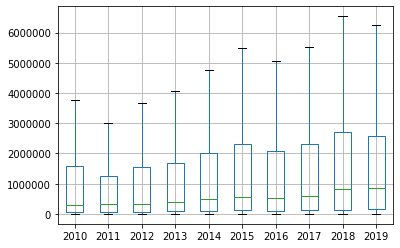

In [640]:
download.boxplot(showfliers=False)

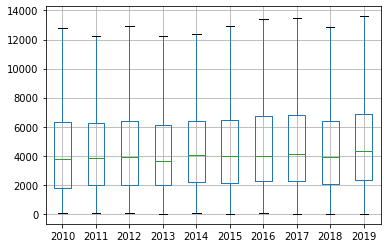

In [471]:
education.boxplot()

In [ ]:
# step 5: adjust expenditure to deflate the nominal value to real value
# data come from World Bank, https://data.worldbank.org/indicator/NY.GDP.DEFL.ZS?locations=CN

In [121]:
GDP_deflator_base2015 = [87.6026842154906, 94.6771234109645, 96.8879484999322, 98.981715613234, 100.00343874309, 100, 
                101.407386250794, 105.700615540204, 109.397987040588, 111.128411979205]

In [122]:
GDP_deflator_base2019 = [v/GDP_deflator_base2015[-1] for v in GDP_deflator_base2015]

In [123]:
GDP_deflator_base2019

[0.7883014132504955,
 0.8519614536441054,
 0.8718557817424983,
 0.8906967520759321,
 0.8998908286550809,
 0.8998598847854731,
 0.9125243890803546,
 0.9511574372176156,
 0.984428600141062,
 1.0]

In [277]:
expenditureTotal[expenditureTotal.index==""]
# drop the rows with all nan values

Empty DataFrame
Columns: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
Index: []

In [278]:
# Nominal GDP=GDP Deflator×Real GDP
expenditureTotalAdjusted = expenditureTotal.divide(GDP_deflator_base2019)
expenditureLiteratureEAdjusted = expenditureLiteratureE.divide(GDP_deflator_base2019)
expenditureLiteraturePAdjusted = expenditureLiterature.divide(GDP_deflator_base2019)

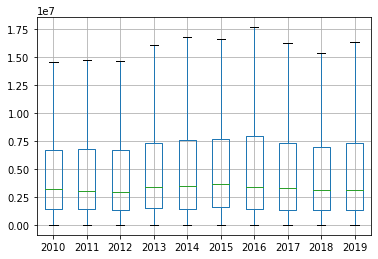

In [263]:
expenditureTotalAdjusted.boxplot(showfliers=False)

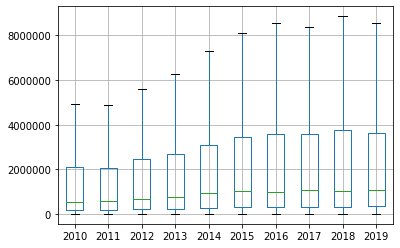

In [142]:
expenditureLiteratureEAdjusted.boxplot(showfliers=False)

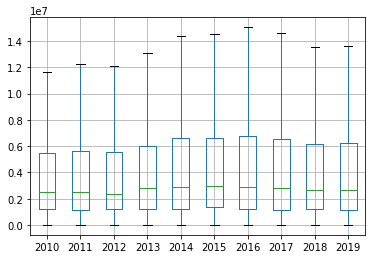

In [143]:
expenditureLiteraturePAdjusted.boxplot(showfliers=False)

To convert nominal economic data from several different years into real, inflation-adjusted data, the starting point is to choose a base year arbitrarily and then use a price index to convert the measurements so that they are measured in the money prevailing in the base year.

The real value refers to the same statistic after it has been adjusted for inflation

https://www.khanacademy.org/economics-finance-domain/macroeconomics/macro-economic-indicators-and-the-business-cycle/macro-real-vs-nominal-gdp/a/adjusting-nominal-values-to-real-values-cnx

In [279]:
# side away a little bit, let me finish the pilot study on collection/funding
# now serielize expenditure and collection data
docName_pilot = ['expenditureTotal', 'expenditureTotalAdjusted',
                 'expenditureLiteratureE','expenditureLiteratureP',
                 'expenditureLiteratureEAdjusted', 'expenditureLiteraturePAdjusted',
                'collection', 'collectionEB', 'collectionEJ', 'collectionPB', 'collectionPJ']

In [280]:
# serialize data to ./pilot
for doc in docName_pilot:
#     with open('./'+doc+'.json', 'w') as f:
    exec("""%s.to_pickle('./pilot/'+%s+'.pickle')""" % (doc, 'str(doc)'))